In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.metrics import average_precision_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet("DATA/train")

In [3]:
LABEL = "fraud"

def evaluate_numeric_feature(df: pd.DataFrame, feature: str) -> pd.Series:
    s = df[feature].astype(float)          # statsmodels/metric 안정화
    y = df[LABEL].astype(int)

    x_nf = s[y == 0]
    x_f  = s[y == 1]

    # KS / MW
    ks_stat, ks_p = ks_2samp(x_nf, x_f)
    mw_stat, mw_p = mannwhitneyu(x_nf, x_f, alternative="two-sided")

    # Cohen's d (pooled std=0 방지)
    nx, nz = len(x_f), len(x_nf)
    sx, sz = x_f.std(), x_nf.std()
    pooled = np.sqrt(((nx - 1) * sx**2 + (nz - 1) * sz**2) / (nx + nz - 2))
    d = np.nan if pooled == 0 or np.isnan(pooled) else (x_f.mean() - x_nf.mean()) / pooled

    # 단변량 PR-AUC (방향성 보정)
    pr_auc = max(
        average_precision_score(y, s),
        average_precision_score(y, -s),
    )

    # 단변량 logit
    odds_ratio = np.nan
    logit_p = np.nan
    try:
        X = sm.add_constant(s.to_frame(name=feature))
        model = sm.Logit(y, X).fit(disp=0)
        odds_ratio = float(np.exp(model.params[feature]))
        logit_p = float(model.pvalues[feature])
    except Exception:
        pass

    return pd.Series({
        "KS_p": float(ks_p),
        "MW_p": float(mw_p),
        "Cohen_d": float(d) if np.isfinite(d) else np.nan,
        "Odds_Ratio": float(odds_ratio) if np.isfinite(odds_ratio) else np.nan,
        "Logit_p": float(logit_p) if np.isfinite(logit_p) else np.nan,
        "PR_AUC": float(pr_auc),
        "n": int(len(s)),
        "pos_rate": float(y.mean()),
    })



EXCLUDE = {"date", "client_id", "card_id", "merchant_id", LABEL}

candidate_features = [
    c for c in df.columns
    if c not in EXCLUDE and pd.api.types.is_numeric_dtype(df[c])
]

rows = []
for f in tqdm(candidate_features, desc="Univariate feature screening"):
    # 상수 컬럼이면 스킵(안정성)
    if df[f].nunique() <= 1:
        continue
    r = evaluate_numeric_feature(df, f)
    r.name = f
    rows.append(r)

res = pd.DataFrame(rows)
res.index.name = "feature"

res_sorted = res.sort_values("PR_AUC", ascending=False)

Univariate feature screening:   0%|          | 0/55 [00:00<?, ?it/s]

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [4]:
res_sorted.to_csv("artifacts/univariate_screening_train.csv", encoding="utf-8-sig")

In [5]:
res_sorted

,KS_p,MW_p,Cohen_d,Odds_Ratio,Logit_p,PR_AUC,n,pos_rate
feature,,,,,,,,
mccg_Industrial_/_Manufacturing,3.773248e-63,0.000000e+00,3.293001,NaN,NaN,0.114718,609655.0,0.010823
amount_income_ratio,0.000000e+00,0.000000e+00,0.245297,1.039845e+00,4.200211e-18,0.034765,609655.0,0.010823
log_abs_amount,0.000000e+00,0.000000e+00,0.647072,1.905734e+00,0.000000e+00,0.034671,609655.0,0.010823
amount,0.000000e+00,0.000000e+00,0.657115,1.002283e+00,0.000000e+00,0.030839,609655.0,0.010823
amount_limit_ratio,0.000000e+00,6.891895e-251,0.104653,1.000000e+00,1.189246e-05,0.028809,609655.0,0.010823
mccg_Retail,8.023514e-150,0.000000e+00,1.206827,1.268877e+01,0.000000e+00,0.027459,609655.0,0.010823
mccg_Food_Daily,0.000000e+00,0.000000e+00,1.088365,7.054591e+00,0.000000e+00,0.025363,609655.0,0.010823
mccg_Transport_Travel,0.000000e+00,0.000000e+00,-1.108233,7.019452e-02,0.000000e+00,0.024655,609655.0,0.010823
tx_year,1.563508e-242,1.871666e-09,-0.093446,9.467382e-01,4.625980e-14,0.015941,609655.0,0.010823


In [6]:
df.shape

(609655, 60)

### Logit_p 기준 filtering

In [7]:
alpha = 0.05

sig = res_sorted[
    (res_sorted["Logit_p"] < alpha) &
    (res_sorted["KS_p"] < alpha) &
    (res_sorted["MW_p"] < alpha)
].copy()

sig_feature_names = sig.index.tolist()
print(f"kept_features = {len(sig_feature_names)}")

kept_features = 34


In [8]:
sig_feature_names

['amount_income_ratio',
 'log_abs_amount',
 'amount',
 'amount_limit_ratio',
 'mccg_Retail',
 'mccg_Food_Daily',
 'mccg_Transport_Travel',
 'tx_year',
 'per_capita_income',
 'is_refund',
 'yearly_income',
 'log_yearly_income',
 'credit_limit',
 'mccg_Financial',
 'income_ratio_region',
 'log_income_ratio_region',
 'tx_hour',
 'num_credit_cards',
 'total_debt',
 'years_to_retirement',
 'year_pin_last_changed',
 'tx_month',
 'current_age',
 'is_prepaid',
 'mccg_Digital_Online',
 'is_weekend',
 'mccg_Utilities_Government',
 'tx_day',
 'mccg_Automotive_Home',
 'has_error',
 'months_from_account',
 'cb_Visa',
 'has_chip',
 'credit_score']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609655 entries, 5 to 5332941
Data columns (total 60 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             609655 non-null  datetime64[ns]
 1   client_id                        609655 non-null  int64         
 2   card_id                          609655 non-null  int64         
 3   amount                           609655 non-null  float32       
 4   merchant_id                      609655 non-null  int64         
 5   current_age                      609655 non-null  int64         
 6   per_capita_income                609655 non-null  float32       
 7   yearly_income                    609655 non-null  float32       
 8   total_debt                       609655 non-null  float32       
 9   credit_score                     609655 non-null  int64         
 10  num_credit_cards                 609655 non-null

---

## 0) 식별자/메타 컬럼 (분석은 ‘분리/집계’ 목적, 모델엔 보통 제외)

* `date` : 시계열 분포/드리프트/계절성 확인용 (모델 입력은 보통 time feature로만)
* `client_id` : 고객 단위 집계 피처 만들 때 키
* `card_id` : 카드 단위 집계/행동 피처 만들 때 키
* `merchant_id` : 가맹점 단위 집계/위험도 피처 만들 때 키

**분석 포인트**

* 키별 거래수 분포(heavy user / heavy merchant)
* fraud가 특정 key에 몰리는지(집중도)
* key별 “과거 이력 기반” 피처 만들 여지
---

In [10]:
LABEL = "fraud"

### 1️⃣ date — 시계열 분포 & fraud drift

1-1) 월별 거래 수

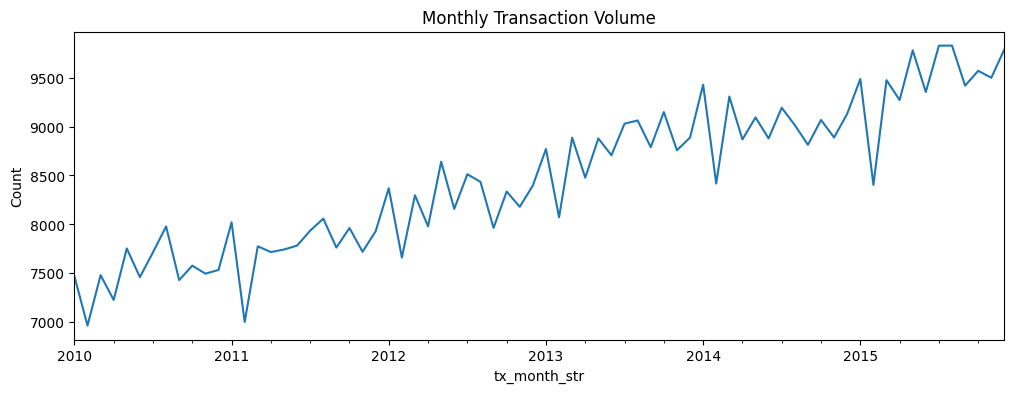

In [11]:
monthly_tx = (
    df
    .assign(tx_month_str=df["date"].dt.to_period("M"))
    .groupby("tx_month_str")
    .size()
)

plt.figure(figsize=(12,4))
monthly_tx.plot()
plt.title("Monthly Transaction Volume")
plt.ylabel("Count")
plt.show()

1-2) 월별 fraud rate

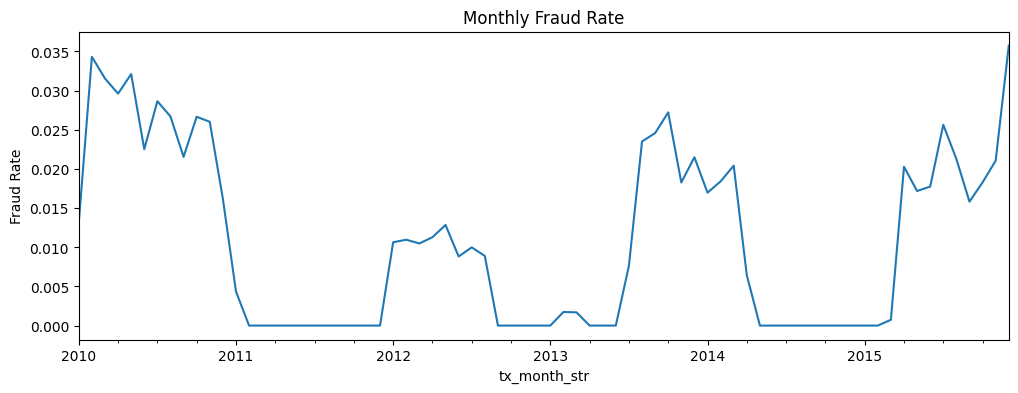

In [12]:
monthly_fraud = (
    df
    .assign(tx_month_str=df["date"].dt.to_period("M"))
    .groupby("tx_month_str")[LABEL]
    .mean()
)

plt.figure(figsize=(12,4))
monthly_fraud.plot()
plt.title("Monthly Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()


### 2️⃣ client_id — 고객 단위 분석

2-1) 고객별 거래 수 분포

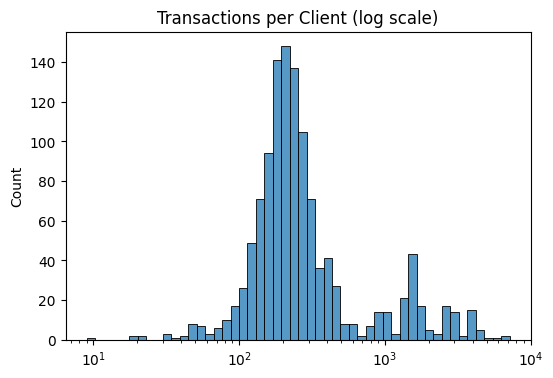

In [13]:
client_tx_count = df.groupby("client_id").size()

plt.figure(figsize=(6,4))
sns.histplot(client_tx_count, bins=50, log_scale=True)
plt.title("Transactions per Client (log scale)")
plt.show()

2-2) 고객별 fraud rate

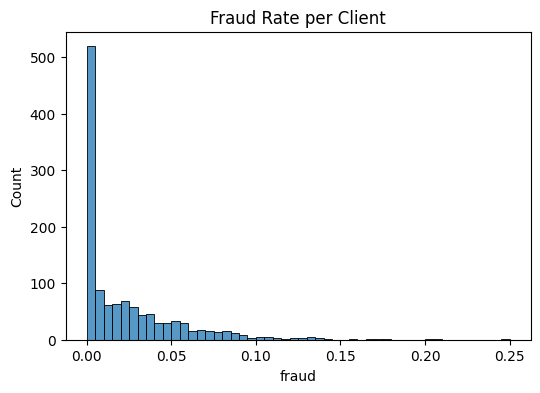

In [14]:
client_fraud_rate = df.groupby("client_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(client_fraud_rate, bins=50)
plt.title("Fraud Rate per Client")
plt.show()

2-3) fraud 집중도 (상위 고객 비율)

In [15]:
client_fraud_sum = df.groupby("client_id")[LABEL].sum()
top_clients = client_fraud_sum.sort_values(ascending=False)

top_10_ratio = top_clients.head(10).sum() / df[LABEL].sum()

print("Top 10 clients fraud concentration:", top_10_ratio)


Top 10 clients fraud concentration: 0.047135495604728704


### 3️⃣ card_id 분석

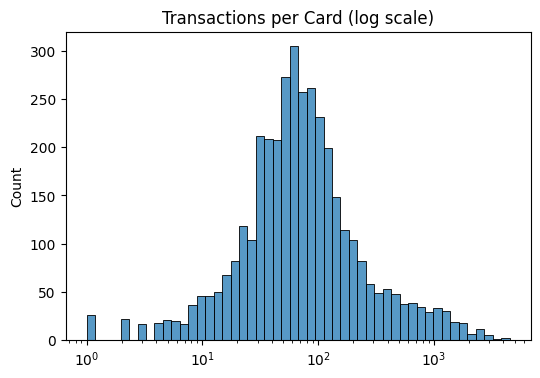

In [16]:
card_tx_count = df.groupby("card_id").size()

plt.figure(figsize=(6,4))
sns.histplot(card_tx_count, bins=50, log_scale=True)
plt.title("Transactions per Card (log scale)")
plt.show()

카드별 fraud rate

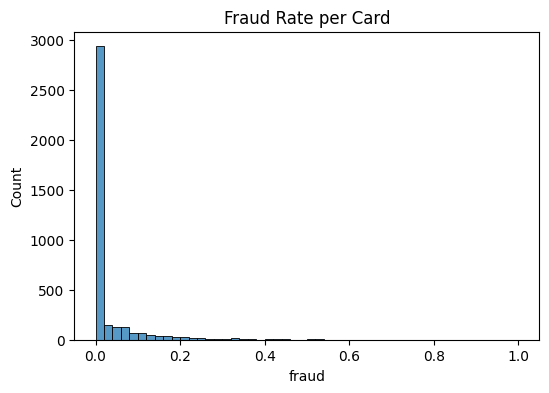

In [17]:
card_fraud_rate = df.groupby("card_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(card_fraud_rate, bins=50)
plt.title("Fraud Rate per Card")
plt.show()


### 4️⃣ merchant_id — 가맹점 위험도

4-1) 가맹점별 거래 수

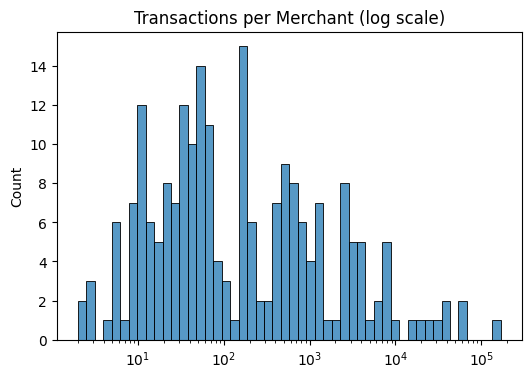

In [18]:
merchant_tx = df.groupby("merchant_id").size()

plt.figure(figsize=(6,4))
sns.histplot(merchant_tx, bins=50, log_scale=True)
plt.title("Transactions per Merchant (log scale)")
plt.show()


4-2) 가맹점별 fraud rate

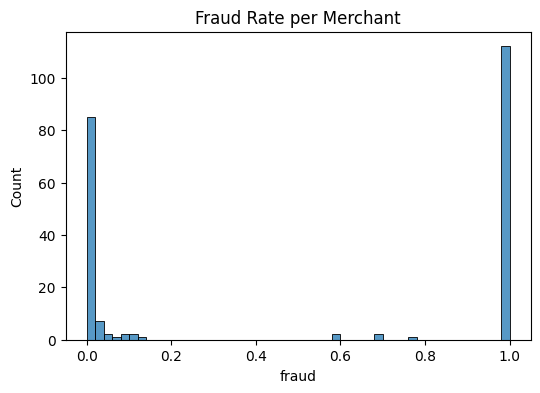

In [19]:
merchant_fraud = df.groupby("merchant_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(merchant_fraud, bins=50)
plt.title("Fraud Rate per Merchant")
plt.show()

4-3) fraud 집중도 (상위 가맹점)

In [20]:
merchant_fraud_sum = df.groupby("merchant_id")[LABEL].sum()
top_merchants = merchant_fraud_sum.sort_values(ascending=False)

top_10_ratio = top_merchants.head(10).sum() / df[LABEL].sum()

print("Top 10 merchants fraud concentration:", top_10_ratio)

Top 10 merchants fraud concentration: 0.3258563200969991


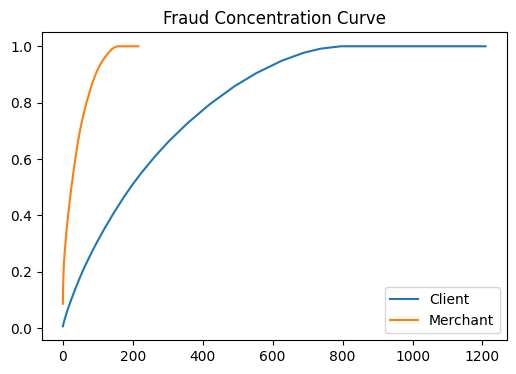

In [21]:
def concentration_ratio(group_sum):
    total = group_sum.sum()
    sorted_vals = group_sum.sort_values(ascending=False)
    cum = sorted_vals.cumsum() / total
    return cum

client_conc = concentration_ratio(client_fraud_sum)
merchant_conc = concentration_ratio(merchant_fraud_sum)

plt.figure(figsize=(6,4))
plt.plot(client_conc.values, label="Client")
plt.plot(merchant_conc.values, label="Merchant")
plt.legend()
plt.title("Fraud Concentration Curve")
plt.show()


### 📊 ID / Meta Column Structural Analysis Summary
1️⃣ Transaction Volume Trend

> 월별 거래량은 전반적으로 지속적인 증가 추세를 보임.\
> 따라서 fraud 건수 자체보다는 fraud rate 기준으로 판단해야 함.\
> 운영 단계에서는 거래량 증가에 따른 threshold 조정 전략이 필요함.

2️⃣ Fraud Rate Seasonality

> 월별 fraud rate는 약 1년 주기의 상승·하락 패턴을 보임.\
> 완전한 랜덤이 아니라 주기적/파동형 구조 존재.\
> 시간 변수는 구조적으로 의미 있는 설명 변수일 가능성이 높음.

3️⃣ Client-Level Pattern

> 대부분의 고객은 fraud가 없음.\
> 일부 고객에서 fraud가 반복적으로 발생.\
> 고객 단위의 이력 기반 리스크 효과가 존재함.\
> 과거 fraud 경험 여부, 누적 fraud 횟수 등은 유의미한 피처가 될 가능성 높음.

4️⃣ Card-Level Pattern

> 카드 단위 반복 fraud는 상대적으로 많지 않음.\
> 카드 레벨 이력 효과는 client 레벨보다 약함.

5️⃣ Merchant-Level Concentration

> fraud가 특정 merchant에 강하게 집중되어 있음.\
> 일부 merchant는 매우 높은 fraud rate를 보임.\
> 구조적 리스크가 merchant 단위에서 발생하는 패턴.\
> merchant risk score 또는 blacklist 관리가 필요할 가능성 높음.

In [22]:
df = df.sort_values("date").copy()

g_client = df.groupby("client_id")["fraud"]
df["client_prev_fraud_cnt"] = (g_client.cumsum() - df["fraud"]).astype("int32")

g_merchant = df.groupby("merchant_id")["fraud"]
df["merchant_prev_fraud_cnt"] = (g_merchant.cumsum() - df["fraud"]).astype("int32")

# 검증: 첫 거래는 무조건 0
print((df.groupby("client_id")["client_prev_fraud_cnt"].head(1) != 0).sum())
print((df.groupby("merchant_id")["merchant_prev_fraud_cnt"].head(1) != 0).sum())

0
0


In [23]:
df["month_sin"] = np.sin(2 * np.pi * df["tx_month"] / 12).astype("float32")
df["month_cos"] = np.cos(2 * np.pi * df["tx_month"] / 12).astype("float32")

In [24]:
df["day_sin"] = np.sin(2 * np.pi * df["tx_day"] / 31).astype("float32")
df["day_cos"] = np.cos(2 * np.pi * df["tx_day"] / 31).astype("float32")

In [25]:
df["hour_sin"] = np.sin(2 * np.pi * df["tx_hour"] / 24).astype("float32")
df["hour_cos"] = np.cos(2 * np.pi * df["tx_hour"] / 24).astype("float32")

In [26]:
cyc_features = [
    "month_sin", "month_cos",
    "day_sin", "day_cos",
    "hour_sin", "hour_cos"
]

for col in cyc_features:
    print(col)
    print(evaluate_numeric_feature(df, col))


month_sin
KS_p          2.809612e-18
MW_p          2.901159e-08
Cohen_d      -6.992024e-02
Odds_Ratio    9.054070e-01
Logit_p       1.650304e-08
PR_AUC        1.139782e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64
month_cos
KS_p               0.005395
MW_p               0.197120
Cohen_d            0.004840
Odds_Ratio         1.006848
Logit_p            0.695780
PR_AUC             0.011032
n             609655.000000
pos_rate           0.010823
dtype: float64
day_sin
KS_p               0.000023
MW_p               0.017653
Cohen_d           -0.034724
Odds_Ratio         0.952486
Logit_p            0.005034
PR_AUC             0.011048
n             609655.000000
pos_rate           0.010823
dtype: float64
day_cos
KS_p               0.016577
MW_p               0.007591
Cohen_d            0.033006
Odds_Ratio         1.048241
Logit_p            0.007674
PR_AUC             0.011106
n             609655.000000
pos_rate           0.010823
dtype: float64
hour_sin
KS_p   

사기가 특정 시간대 / 특정 월 주기 위치에서 비대칭적으로 발생

Month별 Fraud Rate 시각화

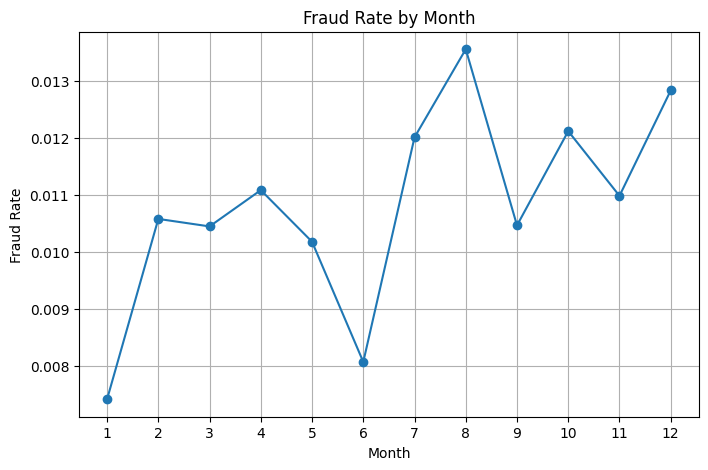

    tx_month      mean  count
0          1  0.007411  51542
1          2  0.010577  46516
2          3  0.010445  51219
3          4  0.011083  49537
4          5  0.010176  51885
5          6  0.008066  50336
6          7  0.012009  52209
7          8  0.013556  52374
8          9  0.010464  50174
9         10  0.012118  51659
10        11  0.010982  50537
11        12  0.012832  51667


In [27]:
# month별 fraud rate
month_stat = (
    df.groupby("tx_month")["fraud"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("tx_month")
)

plt.figure(figsize=(8,5))
plt.plot(month_stat["tx_month"], month_stat["mean"], marker="o")
plt.title("Fraud Rate by Month")
plt.xlabel("Month")
plt.ylabel("Fraud Rate")
plt.xticks(range(1,13))
plt.grid(True)
plt.show()

print(month_stat)


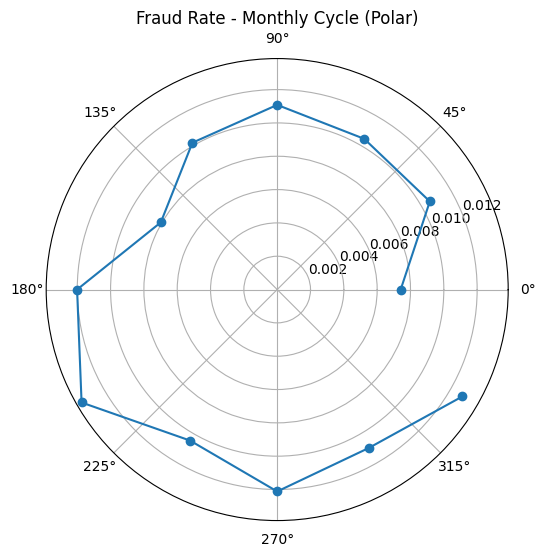

In [28]:
theta = 2 * np.pi * (month_stat["tx_month"] - 1) / 12

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, month_stat["mean"], marker="o")
ax.set_title("Fraud Rate - Monthly Cycle (Polar)")
plt.show()

> 최저: 1월 (~0.0074), 6월 (~0.0081)\
> 최고: 8월 (~0.0136), 12월 (~0.0128), 10월 (~0.0121)

Hour별 Fraud Rate 시각화

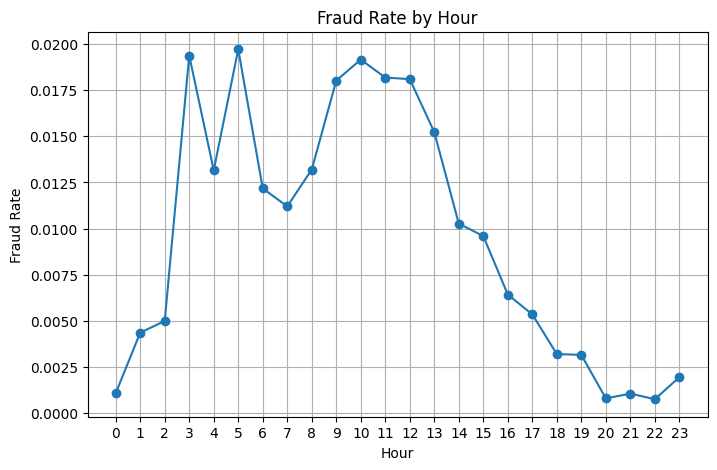

    tx_hour      mean  count
0         0  0.001065  11267
1         1  0.004350   8276
2         2  0.004985   7221
3         3  0.019382   4695
4         4  0.013156   9197
5         5  0.019727   9834
6         6  0.012177  32438
7         7  0.011200  39999
8         8  0.013199  32957
9         9  0.018025  38835
10       10  0.019165  36943
11       11  0.018191  38865
12       12  0.018103  32591
13       13  0.015231  37359
14       14  0.010266  46953
15       15  0.009592  44621
16       16  0.006417  50962
17       17  0.005344  23767
18       18  0.003190  18182
19       19  0.003144  21626
20       20  0.000783  19153
21       21  0.001044  18196
22       22  0.000740  14868
23       23  0.001935  10850


In [29]:
hour_stat = (
    df.groupby("tx_hour")["fraud"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("tx_hour")
)

plt.figure(figsize=(8,5))
plt.plot(hour_stat["tx_hour"], hour_stat["mean"], marker="o")
plt.title("Fraud Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

print(hour_stat)


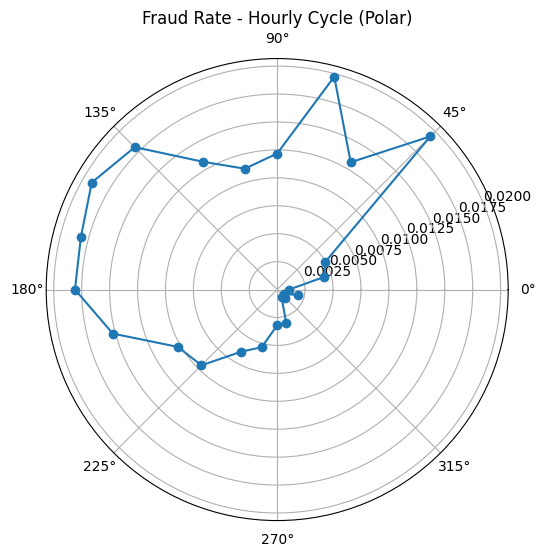

In [30]:
theta = 2 * np.pi * hour_stat["tx_hour"] / 24

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, hour_stat["mean"], marker="o")
ax.set_title("Fraud Rate - Hourly Cycle (Polar)")
plt.show()

🔺 고위험 시간대

    03시 (~1.94%)
    05시 (~1.97%)
    09~12시 (1.8~1.9%)

🔻 저위험 시간대

    20~22시 (0.07~0.1%)
    0시 (0.1%)

---

## 1) 타깃/라벨

* `fraud` : 0/1

**분석 포인트**

* base rate
* 클래스 비율 변화(시간축 drift)

---

In [31]:
# 전체 base rate
base_rate = df["fraud"].mean()

print(f"Overall Fraud Rate: {base_rate:.6f}")
print(df["fraud"].value_counts(normalize=True))


Overall Fraud Rate: 0.010823
fraud
0    0.989177
1    0.010823
Name: proportion, dtype: float64


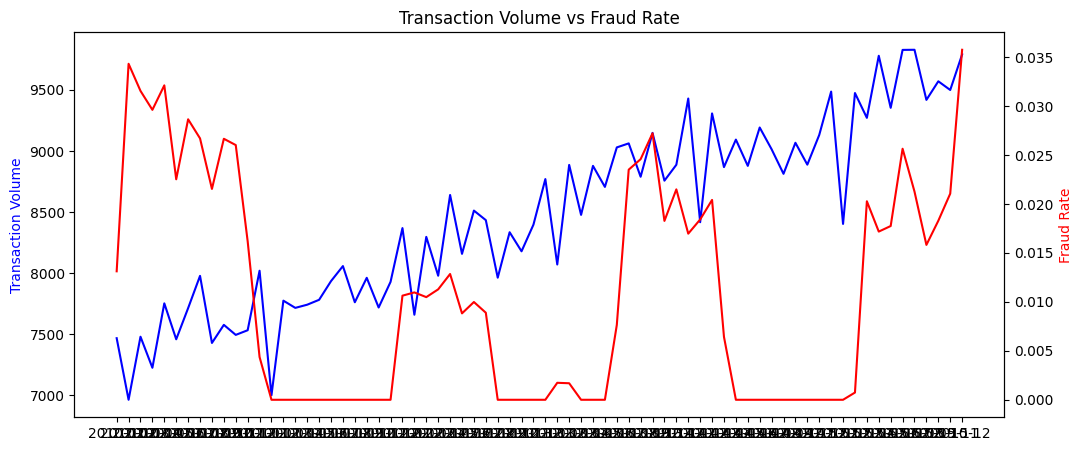

In [32]:
monthly_full = (
    df.groupby(["tx_year", "tx_month"])["fraud"]
      .agg(["mean", "count"])
      .reset_index()
)

monthly_full["year_month"] = (
    monthly_full["tx_year"].astype(str) + "-" +
    monthly_full["tx_month"].astype(str).str.zfill(2)
)

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(monthly_full["year_month"], monthly_full["count"], color="blue")
ax1.set_ylabel("Transaction Volume", color="blue")

ax2 = ax1.twinx()
ax2.plot(monthly_full["year_month"], monthly_full["mean"], color="red")
ax2.set_ylabel("Fraud Rate", color="red")

plt.xticks(rotation=90)
plt.title("Transaction Volume vs Fraud Rate")
plt.show()


In [33]:
q_hi = monthly_full["mean"].quantile(0.75)
q_lo = monthly_full["mean"].quantile(0.25)

print("q_hi:", q_hi, "q_lo:", q_lo)
print("n_high_months:", (monthly_full["mean"] > q_hi).sum())
print("n_low_months :", (monthly_full["mean"] < q_lo).sum())
print("n_eq_qlo     :", (monthly_full["mean"] == q_lo).sum())


q_hi: 0.0205747681639434 q_lo: 0.0
n_high_months: 18
n_low_months : 0
n_eq_qlo     : 29


In [34]:
# 1) quantile
q_hi = monthly_full["mean"].quantile(0.75)
q_lo = monthly_full["mean"].quantile(0.25)

print("q_hi:", q_hi, "q_lo:", q_lo)

# 2) high/low 정의: 너가 말한대로 경계 포함
high_period = monthly_full[monthly_full["mean"] >= q_hi].copy()
low_period  = monthly_full[monthly_full["mean"] <= q_lo].copy()

print("n_high_months:", len(high_period))
print("n_low_months :", len(low_period))

# 3) key 만들기 (여기도 반드시 >=, <= 로)
high_keys = list(zip(high_period["tx_year"], high_period["tx_month"]))
low_keys  = list(zip(low_period["tx_year"],  low_period["tx_month"]))

# 4) df에 period_group 라벨링
df = df.copy()
df["period_group"] = "mid"

pairs = pd.MultiIndex.from_arrays([df["tx_year"], df["tx_month"]])

if len(high_keys) > 0:
    df.loc[pairs.isin(pd.MultiIndex.from_tuples(high_keys)), "period_group"] = "high"

if len(low_keys) > 0:
    df.loc[pairs.isin(pd.MultiIndex.from_tuples(low_keys)), "period_group"] = "low"

# 5) 분리
df_h = df[df["period_group"] == "high"].copy()
df_l = df[df["period_group"] == "low"].copy()

print(df_h.shape, df_l.shape)
print("high fraud rate:", df_h["fraud"].mean(), " low fraud rate:", df_l["fraud"].mean())


q_hi: 0.0205747681639434 q_lo: 0.0
n_high_months: 18
n_low_months : 29
(149905, 69) (243051, 69)
high fraud rate: 0.02653013575264334  low fraud rate: 0.0


In [35]:
EXCLUDE = {
    "fraud", "date", "period_group",
    "client_id", "card_id", "merchant_id"
}

feature_cols = [c for c in df.columns if c not in EXCLUDE]

# 수치형/이진형 분리
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
bin_cols = [c for c in num_cols if df[c].dropna().isin([0, 1]).all()]
cont_cols = [c for c in num_cols if c not in bin_cols]

print("cont:", len(cont_cols), "bin:", len(bin_cols))

cont: 33 bin: 30


In [36]:
from scipy.stats import ks_2samp, mannwhitneyu

def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    if na < 2 or nb < 2:
        return np.nan
    sa, sb = a.std(ddof=1), b.std(ddof=1)
    pooled = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / (na+nb-2))
    return (a.mean() - b.mean()) / (pooled + 1e-12)

rows = []
for col in cont_cols:
    xh = df_h[col].dropna()
    xl = df_l[col].dropna()
    if len(xh) < 30 or len(xl) < 30:
        continue

    ks_p = ks_2samp(xh, xl).pvalue
    mw_p = mannwhitneyu(xh, xl, alternative="two-sided").pvalue
    d = cohens_d(xh, xl)

    rows.append({
        "feature": col,
        "type": "continuous",
        "high_mean": float(xh.mean()),
        "low_mean": float(xl.mean()),
        "delta_mean": float(xh.mean() - xl.mean()),
        "cohen_d": float(d),
        "KS_p": float(ks_p),
        "MW_p": float(mw_p),
        "n_high": int(len(xh)),
        "n_low": int(len(xl)),
    })

res_cont = pd.DataFrame(rows).set_index("feature").sort_values("MW_p")
res_cont.head(10)


,type,high_mean,low_mean,delta_mean,cohen_d,KS_p,MW_p,n_high,n_low
feature,,,,,,,,,
months_to_expire,continuous,106.809806,102.231519,4.578287,0.126375,0.000000e+00,0.000000e+00,149905,243051
tx_month,continuous,8.077062,7.105500,0.971562,0.303798,0.000000e+00,0.000000e+00,149905,243051
tx_year,continuous,2012.017131,2012.605918,-0.588787,-0.341671,0.000000e+00,0.000000e+00,149905,243051
years_since_pin_change,continuous,1.841600,2.105373,-0.263773,-0.123191,0.000000e+00,0.000000e+00,149905,243051
month_sin,continuous,-0.317486,-0.103360,-0.214126,-0.326308,0.000000e+00,0.000000e+00,149905,243051
months_from_account,continuous,67.098442,71.069364,-3.970922,-0.084569,9.899094e-236,1.304036e-205,149905,243051
client_prev_fraud_cnt,continuous,2.615056,2.862753,-0.247697,-0.051422,3.199158e-131,1.047847e-130,149905,243051
merchant_prev_fraud_cnt,continuous,12.285941,13.031282,-0.745340,-0.032461,0.000000e+00,3.751003e-64,149905,243051
credit_limit,continuous,16063.235352,16194.696289,-131.460938,-0.010725,6.893028e-11,4.229329e-07,149905,243051


In [37]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

rows = []
for col in bin_cols:
    xh = df_h[col].astype(int)
    xl = df_l[col].astype(int)

    a1 = int((xh == 1).sum()); a0 = int((xh == 0).sum())
    b1 = int((xl == 1).sum()); b0 = int((xl == 0).sum())

    n_high = a1 + a0
    n_low  = b1 + b0

    if n_high < 30 or n_low < 30:
        continue

    table = np.array([[a1, a0],
                      [b1, b0]], dtype=int)

    # rate
    high_rate = a1 / (n_high + 1e-12)
    low_rate  = b1 / (n_low  + 1e-12)

    # 0 cell이 있으면 Fisher로 
    if (table == 0).any():
        odds, p = fisher_exact(table, alternative="two-sided")
        test = "fisher"
        chi2 = np.nan
    else:
        chi2, p, _, _ = chi2_contingency(table, correction=False)
        odds = (a1 * b0) / (a0 * b1 + 1e-12) 
        test = "chi2"

    rows.append({
        "feature": col,
        "type": "binary",
        "high_rate": float(high_rate),
        "low_rate": float(low_rate),
        "delta_rate": float(high_rate - low_rate),
        "p_value": float(p),
        "test": test,
        "odds_ratio": float(odds) if np.isfinite(odds) else np.nan,
        "a1_high": a1, "a0_high": a0,
        "b1_low": b1,  "b0_low": b0,
        "n_high": int(n_high),
        "n_low": int(n_low),
    })

res_bin = pd.DataFrame(rows).set_index("feature").sort_values("p_value")
res_bin.head(20)


,type,high_rate,low_rate,delta_rate,p_value,test,odds_ratio,a1_high,a0_high,b1_low,b0_low,n_high,n_low
feature,,,,,,,,,,,,,
mccg_Industrial_/_Manufacturing,binary,0.002755,0.000000,0.002755,9.893928e-174,fisher,NaN,413,149492,0,243051,149905,243051
mccg_Retail,binary,0.021620,0.016869,0.004751,1.187703e-26,chi2,1.287895,3241,146664,4100,238951,149905,243051
mccg_Food_Daily,binary,0.085267,0.077202,0.008065,1.592069e-19,chi2,1.114210,12782,137123,18764,224287,149905,243051
mccg_Transport_Travel,binary,0.626557,0.640327,-0.013770,3.051485e-18,chi2,0.942416,93924,55981,155632,87419,149905,243051
is_refund,binary,0.006658,0.005764,0.000893,4.793051e-04,chi2,1.156017,998,148907,1401,241650,149905,243051
has_chip,binary,0.915840,0.913491,0.002349,1.058767e-02,chi2,1.030549,137289,12616,222025,21026,149905,243051
err_insufficient_balance,binary,0.007371,0.008089,-0.000718,1.309787e-02,chi2,0.910639,1105,148800,1966,241085,149905,243051
is_prepaid,binary,0.076515,0.074454,0.002062,1.731859e-02,chi2,1.029984,11470,138435,18096,224955,149905,243051
is_weekend,binary,0.287335,0.283998,0.003337,2.441658e-02,chi2,1.016489,43073,106832,69026,174025,149905,243051


In [38]:
alpha = 0.05

sig_cont = res_cont[
    (res_cont["MW_p"] < alpha) &
    (res_cont["KS_p"] < alpha) &
    (res_cont["cohen_d"].abs() >= 0.10)
].sort_values("MW_p")

sig_cont.head(30)


,type,high_mean,low_mean,delta_mean,cohen_d,KS_p,MW_p,n_high,n_low
feature,,,,,,,,,
months_to_expire,continuous,106.809806,102.231519,4.578287,0.126375,0.0,0.0,149905,243051
tx_month,continuous,8.077062,7.105500,0.971562,0.303798,0.0,0.0,149905,243051
tx_year,continuous,2012.017131,2012.605918,-0.588787,-0.341671,0.0,0.0,149905,243051
years_since_pin_change,continuous,1.841600,2.105373,-0.263773,-0.123191,0.0,0.0,149905,243051
month_sin,continuous,-0.317486,-0.103360,-0.214126,-0.326308,0.0,0.0,149905,243051


In [39]:
alpha = 0.05
min_delta = 0.005 

sig_bin = res_bin[
    (res_bin["p_value"] < alpha) &
    (res_bin["delta_rate"].abs() >= min_delta)
].sort_values("p_value")

print("kept:", len(sig_bin))
sig_bin.head(30)


kept: 2


,type,high_rate,low_rate,delta_rate,p_value,test,odds_ratio,a1_high,a0_high,b1_low,b0_low,n_high,n_low
feature,,,,,,,,,,,,,
mccg_Food_Daily,binary,0.085267,0.077202,0.008065,1.592069e-19,chi2,1.114210,12782,137123,18764,224287,149905,243051
mccg_Transport_Travel,binary,0.626557,0.640327,-0.013770,3.051485e-18,chi2,0.942416,93924,55981,155632,87419,149905,243051


High fraud period는

> 특정 계절에 집중\
> PIN 변경 직후 기간과 연관\
> 카드 만료 기간과 약한 연관

-> sin, cos 넣은 것은 합리적


---

## 2) 거래 금액/결제 이벤트 핵심 (가장 직접적인 신호)

* `amount`
* `is_refund` (amount<0)
* `log_abs_amount`
* `amount_income_ratio`
* `amount_limit_ratio`

**분석 포인트**

* fraud vs non-fraud 분포(특히 long-tail)
* refund(음수) 케이스가 fraud와 실제로 연관 있는지
* ratio류(소득/한도 대비)가 “극단값”에서만 먹는지
* 금액 관련 파생끼리 상관/중복 여부

---


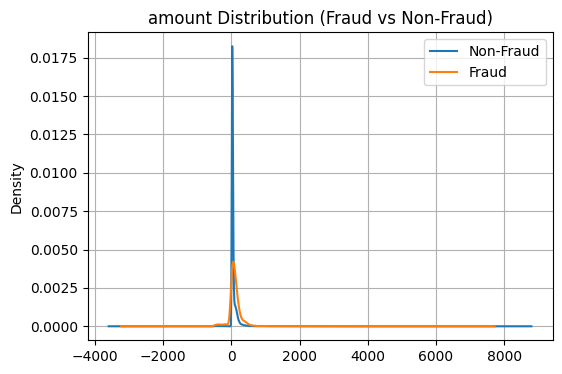

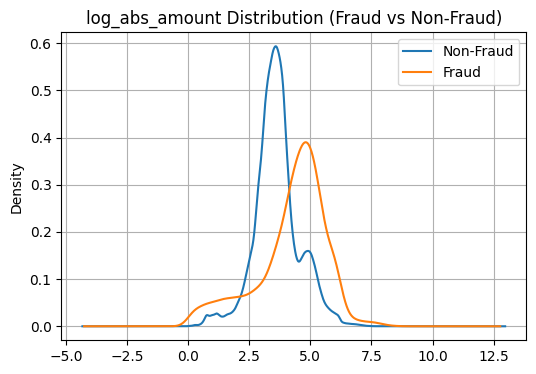

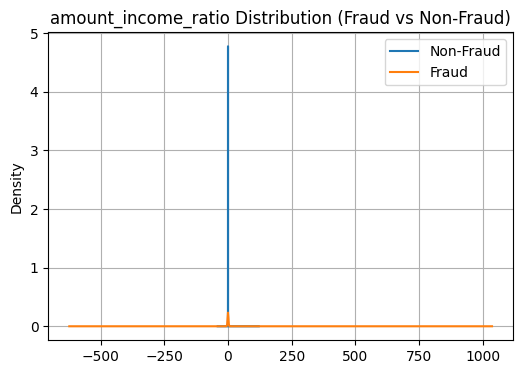

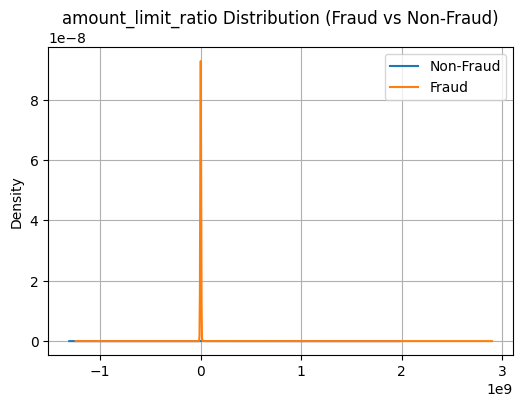

In [40]:
money_cols = [
    "amount",
    "log_abs_amount",
    "amount_income_ratio",
    "amount_limit_ratio"
]

for col in money_cols:
    plt.figure(figsize=(6,4))
    
    df[df["fraud"] == 0][col].plot(kind="kde", label="Non-Fraud")
    df[df["fraud"] == 1][col].plot(kind="kde", label="Fraud")
    
    plt.title(f"{col} Distribution (Fraud vs Non-Fraud)")
    plt.legend()
    plt.grid(True)
    plt.show()


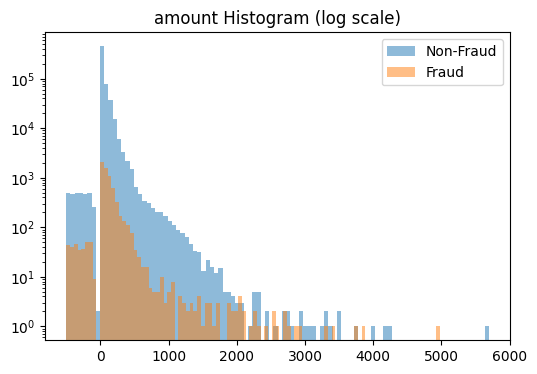

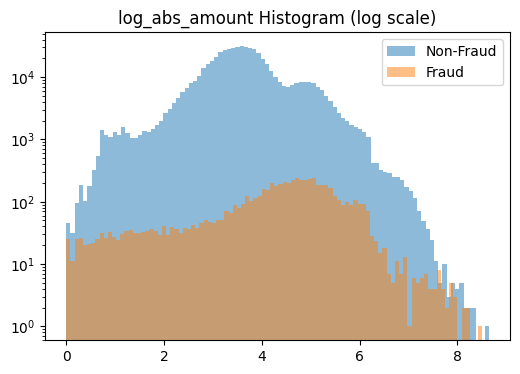

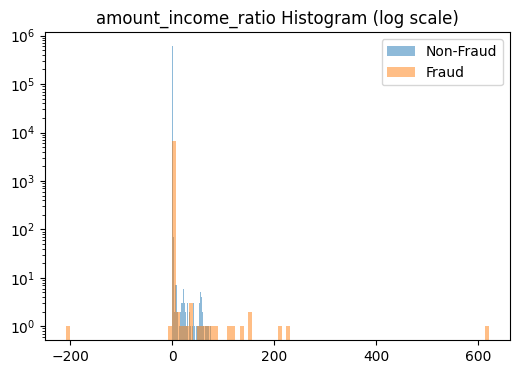

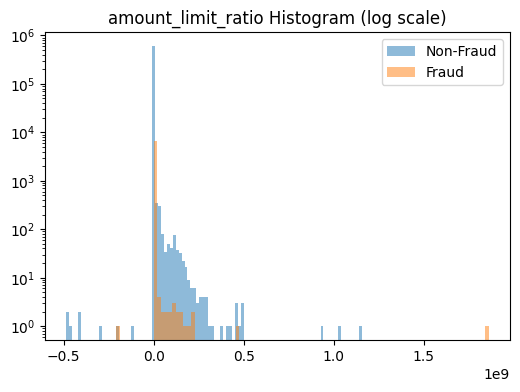

In [41]:
for col in money_cols:
    plt.figure(figsize=(6,4))
    
    plt.hist(df[df["fraud"]==0][col], bins=100, alpha=0.5, label="Non-Fraud")
    plt.hist(df[df["fraud"]==1][col], bins=100, alpha=0.5, label="Fraud")
    
    plt.yscale("log")
    plt.title(f"{col} Histogram (log scale)")
    plt.legend()
    plt.show()

In [42]:
for col in money_cols:
    print(f"\n===== Statistical Test: {col} =====")
    print(evaluate_numeric_feature(df, col))


===== Statistical Test: amount =====
KS_p               0.000000
MW_p               0.000000
Cohen_d            0.657115
Odds_Ratio         1.002283
Logit_p            0.000000
PR_AUC             0.030839
n             609655.000000
pos_rate           0.010823
dtype: float64

===== Statistical Test: log_abs_amount =====
KS_p               0.000000
MW_p               0.000000
Cohen_d            0.647072
Odds_Ratio         1.905734
Logit_p            0.000000
PR_AUC             0.034671
n             609655.000000
pos_rate           0.010823
dtype: float64

===== Statistical Test: amount_income_ratio =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       2.452971e-01
Odds_Ratio    1.039845e+00
Logit_p       4.200211e-18
PR_AUC        3.476515e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64

===== Statistical Test: amount_limit_ratio =====
KS_p           0.000000e+00
MW_p          6.891895e-251
Cohen_d        1.046532e-01
Odds_Ratio     1.00000

In [43]:
refund_stats = df.groupby("fraud")["is_refund"].mean()
print("Refund rate by fraud:")
print(refund_stats)

Refund rate by fraud:
fraud
0    0.005300
1    0.047135
Name: is_refund, dtype: float64


In [44]:
from scipy.stats import chi2_contingency, fisher_exact

a1 = ((df["fraud"]==1) & (df["is_refund"]==1)).sum()
a0 = ((df["fraud"]==1) & (df["is_refund"]==0)).sum()
b1 = ((df["fraud"]==0) & (df["is_refund"]==1)).sum()
b0 = ((df["fraud"]==0) & (df["is_refund"]==0)).sum()

table = np.array([[a1,a0],[b1,b0]])

if (table==0).any():
    odds, p = fisher_exact(table)
    print("Fisher p:", p, "odds_ratio:", odds)
else:
    chi2,p,_,_ = chi2_contingency(table)
    print("Chi2 p:", p)


Chi2 p: 0.0


In [45]:
df[df["is_refund"] == 1]["fraud"].mean()

np.float64(0.08867978329056174)

refund × client 과거 fraud 이력 관계

In [46]:
df.groupby(df["client_prev_fraud_cnt"] > 0)["is_refund"].mean()

client_prev_fraud_cnt
False    0.005590
True     0.006018
Name: is_refund, dtype: float64

refund & fraud 거래의 amount 분포

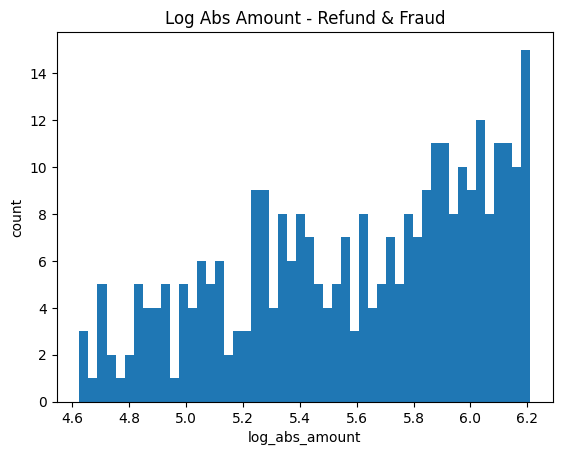

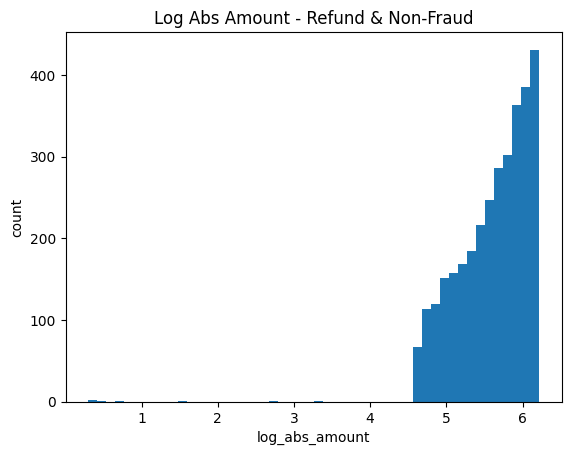

Mean amount (refund+fraud): -294.6045
Mean amount (refund+nonfraud): -296.72803


In [47]:
df_rf = df[(df["is_refund"] == 1) & (df["fraud"] == 1)]
df_rn = df[(df["is_refund"] == 1) & (df["fraud"] == 0)]

plt.figure()
plt.hist(np.log1p(np.abs(df_rf["amount"])), bins=50)
plt.title("Log Abs Amount - Refund & Fraud")
plt.xlabel("log_abs_amount")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(np.abs(df_rn["amount"])), bins=50)
plt.title("Log Abs Amount - Refund & Non-Fraud")
plt.xlabel("log_abs_amount")
plt.ylabel("count")
plt.show()

print("Mean amount (refund+fraud):", df_rf["amount"].mean())
print("Mean amount (refund+nonfraud):", df_rn["amount"].mean())

> refund & fraud는 고금액 쪽에 몰려 있음

refund & fraud 거래의 merchant 분포

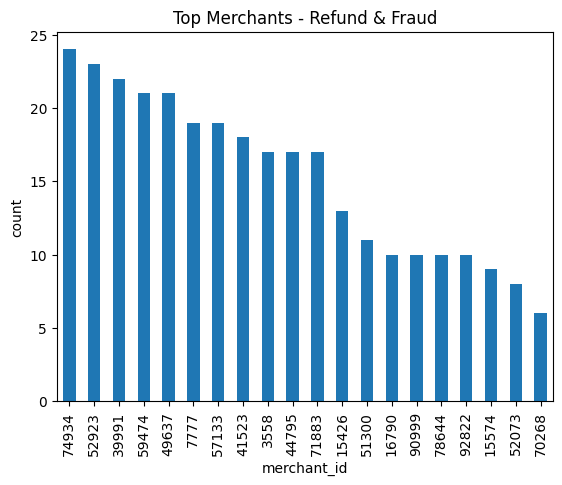

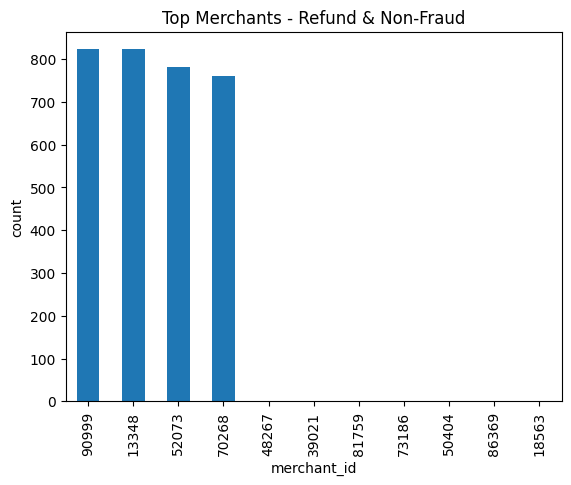

Unique merchants (refund+fraud): 21
Unique merchants (refund+nonfraud): 11


In [48]:
top_rf = (
    df_rf["merchant_id"]
    .value_counts()
    .head(20)
)

top_rn = (
    df_rn["merchant_id"]
    .value_counts()
    .head(20)
)

plt.figure()
top_rf.plot(kind="bar")
plt.title("Top Merchants - Refund & Fraud")
plt.ylabel("count")
plt.show()

plt.figure()
top_rn.plot(kind="bar")
plt.title("Top Merchants - Refund & Non-Fraud")
plt.ylabel("count")
plt.show()

print("Unique merchants (refund+fraud):", df_rf["merchant_id"].nunique())
print("Unique merchants (refund+nonfraud):", df_rn["merchant_id"].nunique())


merchant_prev_fraud_cnt

merchant_refund_fraud_rate

merchant_refund_ratio

refund & fraud 거래의 시간대 분포

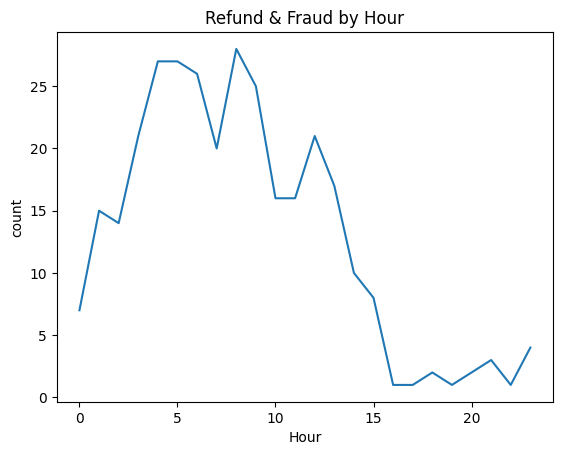

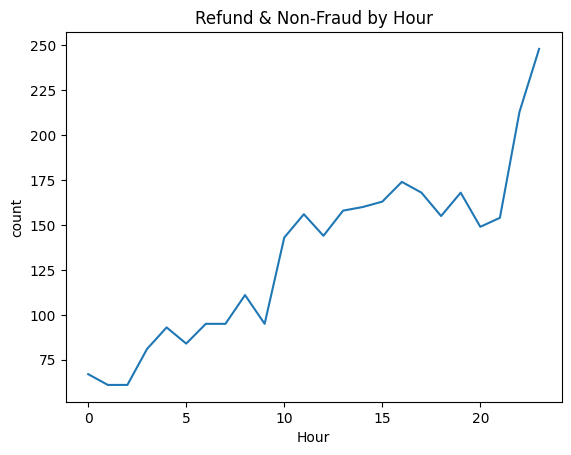

In [49]:
hour_rf = df_rf.groupby("tx_hour")["fraud"].count()
hour_rn = df_rn.groupby("tx_hour")["fraud"].count()

plt.figure()
hour_rf.plot()
plt.title("Refund & Fraud by Hour")
plt.xlabel("Hour")
plt.ylabel("count")
plt.show()

plt.figure()
hour_rn.plot()
plt.title("Refund & Non-Fraud by Hour")
plt.xlabel("Hour")
plt.ylabel("count")
plt.show()


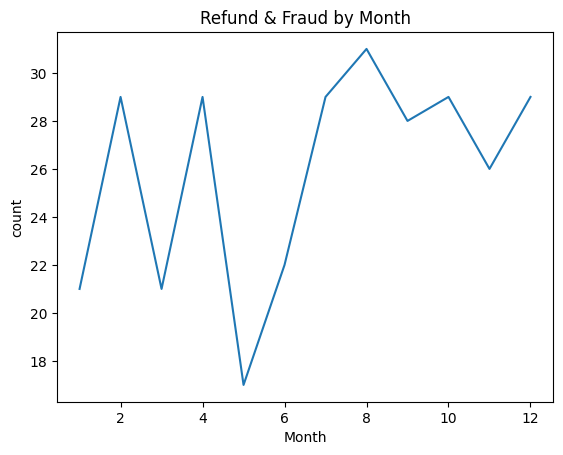

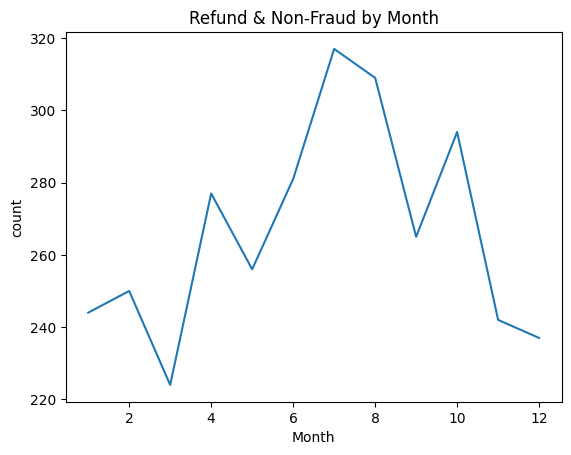

In [50]:
month_rf = df_rf.groupby("tx_month")["fraud"].count()
month_rn = df_rn.groupby("tx_month")["fraud"].count()

plt.figure()
month_rf.plot()
plt.title("Refund & Fraud by Month")
plt.xlabel("Month")
plt.ylabel("count")
plt.show()

plt.figure()
month_rn.plot()
plt.title("Refund & Non-Fraud by Month")
plt.xlabel("Month")
plt.ylabel("count")
plt.show()


In [51]:
df["refund_fraud"] = (
    (df["is_refund"] == 1) &
    (df["fraud"] == 1)
).astype(int)

refund_merchant -> new column

In [52]:
df = df.sort_values(["date", "merchant_id"]).copy()  # tie-break 안정화

g = df.groupby("merchant_id", sort=False)

# 0) 이전 거래 수 (첫 거래는 0)
df["merchant_prev_tx_cnt"] = g.cumcount().astype("int32")

# 1) 이전 fraud 누적 (그룹 안에서 shift!)
df["merchant_prev_fraud_cnt"] = (
    g["fraud"].cumsum()
    .groupby(df["merchant_id"]).shift(1)   # <- 그룹별 shift 보장
    .fillna(0)
    .astype("int32")
)

# 2) 이전 refund 누적
df["merchant_prev_refund_cnt"] = (
    g["is_refund"].cumsum()
    .groupby(df["merchant_id"]).shift(1)
    .fillna(0)
    .astype("int32")
)

# 3) refund 비율 (분모는 이전 거래 수)
df["merchant_refund_ratio"] = (
    df["merchant_prev_refund_cnt"] /
    (df["merchant_prev_tx_cnt"] + 1e-6)
).astype("float32")

# 4) refund&fraud 이벤트 + 이전 누적
df["refund_and_fraud"] = ((df["is_refund"] == 1) & (df["fraud"] == 1)).astype("int8")

df["merchant_prev_refund_fraud_cnt"] = (
    g["refund_and_fraud"].cumsum()
    .groupby(df["merchant_id"]).shift(1)
    .fillna(0)
    .astype("int32")
)

# 5) refund 중 fraud 비율
df["merchant_refund_fraud_rate"] = (
    df["merchant_prev_refund_fraud_cnt"] /
    (df["merchant_prev_refund_cnt"] + 1e-6)
).astype("float32")


In [53]:
print(
    (df.groupby("merchant_id")["merchant_prev_fraud_cnt"].head(1) != 0).sum()
)

print(
    (df.groupby("merchant_id")["merchant_refund_ratio"].head(1) != 0).sum()
)

print(
    (df.groupby("merchant_id")["merchant_refund_fraud_rate"].head(1) != 0).sum()
)

0
0
0


In [54]:
new_cols = [
    "merchant_prev_fraud_cnt",
    "merchant_prev_refund_cnt",
    "merchant_refund_ratio",
    "merchant_prev_refund_fraud_cnt",
    "merchant_refund_fraud_rate"
]

for col in new_cols:
    print(f"\n===== {col} =====")
    print(evaluate_numeric_feature(df, col))



===== merchant_prev_fraud_cnt =====
KS_p               0.000000
MW_p               0.000000
Cohen_d            2.540732
Odds_Ratio         1.032250
Logit_p            0.000000
PR_AUC             0.204854
n             609655.000000
pos_rate           0.010823
dtype: float64

===== merchant_prev_refund_cnt =====
KS_p           0.000000e+00
MW_p          1.624450e-247
Cohen_d       -1.242459e-04
Odds_Ratio     9.999982e-01
Logit_p        9.919914e-01
PR_AUC         1.454899e-02
n              6.096550e+05
pos_rate       1.082251e-02
dtype: float64

===== merchant_refund_ratio =====
KS_p           0.000000e+00
MW_p          4.807730e-215
Cohen_d        1.013389e+00
Odds_Ratio     2.380658e+03
Logit_p        0.000000e+00
PR_AUC         1.031913e-01
n              6.096550e+05
pos_rate       1.082251e-02
dtype: float64

===== merchant_prev_refund_fraud_cnt =====
KS_p          4.173445e-79
MW_p          0.000000e+00
Cohen_d       1.608512e+00
Odds_Ratio    1.532757e+00
Logit_p       0.00000

In [55]:
df.groupby("merchant_id")["fraud"].mean().describe()

count    217.000000
mean       0.536413
std        0.490021
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: fraud, dtype: float64

이 데이터는:\
Behavioral fraud보단\
Merchant-structural fraud\
성격이 강하다.

merchant ID 기반으로 거의 기억하고 있는 상태 우려

[test용 성능 측정]

In [56]:
LABEL = "fraud"
DROP_ALWAYS = ["date", "client_id", "card_id", "merchant_id", LABEL]

df = df.sort_values("date").copy()

split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

# 숫자 컬럼만 선택
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# drop
feature_cols = [c for c in num_cols if c not in DROP_ALWAYS]

X_train = train_df[feature_cols]
y_train = train_df[LABEL].astype(int)

X_test  = test_df[feature_cols]
y_test  = test_df[LABEL].astype(int)


In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)

train_proba = pipe.predict_proba(X_train)[:, 1]
test_proba  = pipe.predict_proba(X_test)[:, 1]

print("TRAIN PR-AUC:", average_precision_score(y_train, train_proba))
print("TEST  PR-AUC:", average_precision_score(y_test, test_proba))
print("TRAIN ROC-AUC:", roc_auc_score(y_train, train_proba))
print("TEST  ROC-AUC:", roc_auc_score(y_test, test_proba))
print("n_features:", len(feature_cols))


TRAIN PR-AUC: 0.7314828231426891
TEST  PR-AUC: 0.828918907056088
TRAIN ROC-AUC: 0.9717073056775721
TEST  ROC-AUC: 0.9789647313489829
n_features: 70


In [58]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def pick_threshold_by_recall(y_true, y_score, target_recall=0.70):
    prec, rec, thr = precision_recall_curve(y_true, y_score)

    prec_t = prec[:-1]
    rec_t  = rec[:-1]
    thr_t  = thr

    mask = rec_t >= target_recall
    if mask.any():
        best_local = np.argmax(prec_t[mask])
        best_thr = thr_t[mask][best_local]
        best_prec = prec_t[mask][best_local]
        best_rec  = rec_t[mask][best_local]
    else:
        # fallback: best F1
        f1 = 2 * (prec_t * rec_t) / (prec_t + rec_t + 1e-12)
        best_idx = np.argmax(f1)
        best_thr = thr_t[best_idx]
        best_prec = prec_t[best_idx]
        best_rec  = rec_t[best_idx]

    return float(best_thr), float(best_prec), float(best_rec)


In [59]:
from sklearn.metrics import classification_report, confusion_matrix

thr, prec, rec = pick_threshold_by_recall(y_test, test_proba, target_recall=0.70)

y_pred = (test_proba >= thr).astype(int)

print("Threshold:", thr)
print("Precision @ Recall>=0.7:", prec)
print("Recall:", rec)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

alert_rate = y_pred.mean()
print("\nAlert Rate:", alert_rate)


Threshold: 0.5231850539577899
Precision @ Recall>=0.7: 0.9295373665480428
Recall: 0.7006437768240343

Confusion Matrix:
[[180934     99]
 [   558   1306]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9969    0.9995    0.9982    181033
           1     0.9295    0.7006    0.7990      1864

    accuracy                         0.9964    182897
   macro avg     0.9632    0.8500    0.8986    182897
weighted avg     0.9962    0.9964    0.9962    182897


Alert Rate: 0.00768191933164568


In [60]:
merchant_cols = [c for c in X_train.columns if "merchant" in c]

X_train_nm = X_train.drop(columns=merchant_cols)
X_test_nm  = X_test.drop(columns=merchant_cols)

pipe_nm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe_nm.fit(X_train_nm, y_train)

test_proba_nm = pipe_nm.predict_proba(X_test_nm)[:, 1]

print("NO MERCHANT TEST PR-AUC:",
      average_precision_score(y_test, test_proba_nm))


NO MERCHANT TEST PR-AUC: 0.26243877032997137


In [61]:
global_fraud_rate = df["fraud"].mean()

print("Global fraud rate:", global_fraud_rate)

Global fraud rate: 0.010822514372883023


베이지안 추정

In [62]:
alpha = 50  # prior strength

df["merchant_prev_fraud_rate_smooth"] = (
    (df["merchant_prev_fraud_cnt"] + alpha * global_fraud_rate) /
    (df["merchant_prev_tx_cnt"] + alpha)
).astype("float32")

In [63]:
first_rows = df.groupby("merchant_id").head(1)
print((first_rows["merchant_prev_fraud_rate_smooth"] != global_fraud_rate).sum())


217


In [64]:
for a in [10, 30, 50, 100]:
    tmp = (df["merchant_prev_fraud_cnt"] + a * global_fraud_rate) / \
          (df["merchant_prev_tx_cnt"] + a)
    print(a, tmp.describe())


10 count    6.096550e+05
mean     8.550544e-03
std      6.929816e-02
min      6.414824e-07
25%      4.175353e-06
50%      1.039627e-04
75%      1.244270e-03
max      9.829158e-01
dtype: float64
30 count    609655.000000
mean          0.006943
std           0.054504
min           0.000002
25%           0.000013
50%           0.000299
75%           0.001439
max           0.950459
dtype: float64
50 count    609655.000000
mean          0.006167
std           0.047018
min           0.000003
25%           0.000021
50%           0.000459
75%           0.001664
max           0.920099
dtype: float64
100 count    609655.000000
mean          0.005209
std           0.037034
min           0.000006
25%           0.000042
50%           0.000616
75%           0.002132
max           0.852141
dtype: float64


In [65]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix,
)

LABEL = "fraud"
BASE_DROP = ["date", "client_id", "card_id", "merchant_id", LABEL]

def build_Xy(df_: pd.DataFrame):
    X = df_.drop(columns=[c for c in BASE_DROP if c in df_.columns]).copy()
    y = df_[LABEL].astype(int).copy()
    return X, y

def get_num_cols(X: pd.DataFrame):
    return [c for c in X.columns if str(X[c].dtype).startswith(("float", "int"))]

def pick_threshold_by_recall(y_true, y_score, target_recall=0.70):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    prec_t = prec[:-1]
    rec_t  = rec[:-1]
    thr_t  = thr
    mask = rec_t >= target_recall
    if mask.any():
        i = np.argmax(prec_t[mask])
        thr_best = thr_t[mask][i]
        return float(thr_best), float(prec_t[mask][i]), float(rec_t[mask][i]), "prec_max_under_recall"
    # fallback
    f1 = 2 * prec_t * rec_t / (prec_t + rec_t + 1e-12)
    j = np.argmax(f1)
    return float(thr_t[j]), float(prec_t[j]), float(rec_t[j]), "fallback_best_f1"

def fit_eval_time_split(df_train, df_valid, tag, drop_cols_extra=None, target_recall=0.70):
    X_tr, y_tr = build_Xy(df_train)
    X_va, y_va = build_Xy(df_valid)

    if drop_cols_extra:
        X_tr = X_tr.drop(columns=[c for c in drop_cols_extra if c in X_tr.columns])
        X_va = X_va.drop(columns=[c for c in drop_cols_extra if c in X_va.columns])

    num_cols = get_num_cols(X_tr)

    preprocess = ColumnTransformer(
        transformers=[("num", StandardScaler(), num_cols)],
        remainder="drop"
    )

    pipe = Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
    ])

    pipe.fit(X_tr, y_tr)

    tr_proba = pipe.predict_proba(X_tr)[:, 1]
    va_proba = pipe.predict_proba(X_va)[:, 1]

    tr_prauc = average_precision_score(y_tr, tr_proba)
    va_prauc = average_precision_score(y_va, va_proba)

    tr_roc = roc_auc_score(y_tr, tr_proba)
    va_roc = roc_auc_score(y_va, va_proba)

    thr, prec, rec, note = pick_threshold_by_recall(y_va, va_proba, target_recall=target_recall)
    yhat = (va_proba >= thr).astype(int)

    cm = confusion_matrix(y_va, yhat)
    tn, fp, fn, tp = cm.ravel()
    alert_rate = (tp + fp) / len(y_va)

    return {
        "tag": tag,
        "n_train": int(len(df_train)),
        "n_valid": int(len(df_valid)),
        "pos_rate_train": float(y_tr.mean()),
        "pos_rate_valid": float(y_va.mean()),
        "PR_AUC_train": float(tr_prauc),
        "PR_AUC_valid": float(va_prauc),
        "ROC_AUC_train": float(tr_roc),
        "ROC_AUC_valid": float(va_roc),
        "precision@recall>=0.7": float(prec),
        "recall": float(rec),
        "threshold": float(thr),
        "alert_rate": float(alert_rate),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "note": note,
    }


df = df.sort_values("date").copy()

cut = int(len(df) * 0.8)
df_train = df.iloc[:cut].copy()
df_valid = df.iloc[cut:].copy()


merchant_raw_cols = [
    "merchant_prev_fraud_cnt",
    "merchant_prev_refund_cnt",
    "merchant_refund_ratio",
    "merchant_prev_refund_fraud_cnt",
    "merchant_refund_fraud_rate",
]

drop_for_smooth_only = [c for c in merchant_raw_cols if c in df.columns]
drop_for_no_merchant = [c for c in df.columns if c.startswith("merchant_")]


results = []
results.append(fit_eval_time_split(df_train, df_valid, "A_raw_all", drop_cols_extra=None))
results.append(fit_eval_time_split(df_train, df_valid, "B_drop_raw(keep_smooth_if_any)", drop_cols_extra=drop_for_smooth_only))
results.append(fit_eval_time_split(df_train, df_valid, "C_no_merchant", drop_cols_extra=drop_for_no_merchant))

res_df = pd.DataFrame(results).sort_values("PR_AUC_valid", ascending=False)
print(res_df.to_string(index=False))


                           tag  n_train  n_valid  pos_rate_train  pos_rate_valid  PR_AUC_train  PR_AUC_valid  ROC_AUC_train  ROC_AUC_valid  precision@recall>=0.7   recall  threshold  alert_rate   TP    FP  FN     TN                  note
                     A_raw_all   487724   121931        0.009706        0.015287      0.831170      0.880317       0.980355       0.982285               1.000000 0.745172   0.996972    0.011392 1389     0 475 120067 prec_max_under_recall
B_drop_raw(keep_smooth_if_any)   487724   121931        0.009706        0.015287      0.829891      0.880235       0.979161       0.981871               1.000000 0.740343   0.998378    0.011318 1380     0 484 120067 prec_max_under_recall
                 C_no_merchant   487724   121931        0.009706        0.015287      0.363487      0.306561       0.929852       0.910953               0.106288 0.700107   0.007341    0.100696 1305 10973 559 109094 prec_max_under_recall


Raw merchant 카운트보다, 스무딩된 rate만 쓰는 게 더 잘 일반화되고 있다.

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609655 entries, 5 to 5332941
Data columns (total 77 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             609655 non-null  datetime64[ns]
 1   client_id                        609655 non-null  int64         
 2   card_id                          609655 non-null  int64         
 3   amount                           609655 non-null  float32       
 4   merchant_id                      609655 non-null  int64         
 5   current_age                      609655 non-null  int64         
 6   per_capita_income                609655 non-null  float32       
 7   yearly_income                    609655 non-null  float32       
 8   total_debt                       609655 non-null  float32       
 9   credit_score                     609655 non-null  int64         
 10  num_credit_cards                 609655 non-null

In [67]:
drop_cols = [
    "merchant_tx_cnt",
    "merchant_prev_refund_cnt",
    "merchant_refund_ratio",
    "refund_and_fraud",
    "merchant_prev_refund_fraud_cnt",
    "merchant_refund_fraud_rate",
    "merchant_prev_tx_cnt",
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609655 entries, 5 to 5332941
Data columns (total 71 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             609655 non-null  datetime64[ns]
 1   client_id                        609655 non-null  int64         
 2   card_id                          609655 non-null  int64         
 3   amount                           609655 non-null  float32       
 4   merchant_id                      609655 non-null  int64         
 5   current_age                      609655 non-null  int64         
 6   per_capita_income                609655 non-null  float32       
 7   yearly_income                    609655 non-null  float32       
 8   total_debt                       609655 non-null  float32       
 9   credit_score                     609655 non-null  int64         
 10  num_credit_cards                 609655 non-null

In [69]:
LABEL = "fraud"

df = df.sort_values("date").copy()

split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
valid_df = df.iloc[split_idx:].copy()

BASE_DROP = ["date", "client_id", "card_id", "merchant_id", LABEL]

def build_Xy_numeric(data: pd.DataFrame):
    X = data.drop(columns=[c for c in BASE_DROP if c in data.columns]).copy()
    y = data[LABEL].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()
    return X, y

X_train, y_train = build_Xy_numeric(train_df)
X_valid, y_valid = build_Xy_numeric(valid_df)

print("X_train shape:", X_train.shape)
print("dtypes check:\n", X_train.dtypes.value_counts())

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)

train_proba = pipe.predict_proba(X_train)[:, 1]
valid_proba = pipe.predict_proba(X_valid)[:, 1]

print("PR-AUC train:", average_precision_score(y_train, train_proba))
print("PR-AUC valid:", average_precision_score(y_valid, valid_proba))
print("ROC-AUC valid:", roc_auc_score(y_valid, valid_proba))

def pick_threshold(y_true, y_score, target_recall=0.7):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    prec, rec = prec[:-1], rec[:-1]

    mask = rec >= target_recall
    if mask.any():
        best = np.argmax(prec[mask])
        thr_best = thr[mask][best]
        return float(thr_best), float(prec[mask][best]), float(rec[mask][best]), "prec_max_under_recall"
    else:
        f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
        best = np.argmax(f1)
        thr_best = thr[best]
        return float(thr_best), float(prec[best]), float(rec[best]), "fallback_best_f1"

thr, prec, rec, note = pick_threshold(y_valid, valid_proba, target_recall=0.7)

y_pred = (valid_proba >= thr).astype(int)

print("\nThreshold:", thr, "|", note)
print("Precision @ Recall>=0.7:", prec)
print("Recall:", rec)

cm = confusion_matrix(y_valid, y_pred)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_valid, y_pred))

alert_rate = y_pred.mean()
print("\nAlert Rate:", alert_rate)


X_train shape: (487724, 65)
dtypes check:
 int8       36
float32    18
int64       5
int16       3
int32       2
float64     1
Name: count, dtype: int64
PR-AUC train: 0.8261127108336868
PR-AUC valid: 0.8737417994209741
ROC-AUC valid: 0.9757370848844017

Threshold: 0.9981042760628109 | prec_max_under_recall
Precision @ Recall>=0.7: 1.0
Recall: 0.7285407725321889

Confusion Matrix:
 [[120067      0]
 [   506   1358]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    120067
           1       1.00      0.73      0.84      1864

    accuracy                           1.00    121931
   macro avg       1.00      0.86      0.92    121931
weighted avg       1.00      1.00      1.00    121931


Alert Rate: 0.011137446588644398


처음 보는 가맹점에서도 잘 작동하는가?

In [70]:
unique_merchants = df["merchant_id"].unique()
np.random.seed(42)
np.random.shuffle(unique_merchants)

split_point = int(len(unique_merchants) * 0.8)

train_merchants = unique_merchants[:split_point]
valid_merchants = unique_merchants[split_point:]

train_df = df[df["merchant_id"].isin(train_merchants)]
valid_df = df[df["merchant_id"].isin(valid_merchants)]


In [71]:
X_train, y_train = build_Xy_numeric(train_df)
X_valid, y_valid = build_Xy_numeric(valid_df)

print("X_train shape:", X_train.shape)
print("dtypes check:\n", X_train.dtypes.value_counts())

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)

train_proba = pipe.predict_proba(X_train)[:, 1]
valid_proba = pipe.predict_proba(X_valid)[:, 1]

print("PR-AUC train:", average_precision_score(y_train, train_proba))
print("PR-AUC valid:", average_precision_score(y_valid, valid_proba))
print("ROC-AUC valid:", roc_auc_score(y_valid, valid_proba))

X_train shape: (542375, 65)
dtypes check:
 int8       36
float32    18
int64       5
int16       3
int32       2
float64     1
Name: count, dtype: int64
PR-AUC train: 0.8486660976650893
PR-AUC valid: 0.8003537546873255
ROC-AUC valid: 0.9553196214155137


In [72]:
thr, prec, rec, note = pick_threshold(y_valid, valid_proba, target_recall=0.7)

y_pred = (valid_proba >= thr).astype(int)

print("\nThreshold:", thr, "|", note)
print("Precision @ Recall>=0.7:", prec)
print("Recall:", rec)

cm = confusion_matrix(y_valid, y_pred)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_valid, y_pred))

alert_rate = y_pred.mean()
print("\nAlert Rate:", alert_rate)


Threshold: 0.2151227295503994 | prec_max_under_recall
Precision @ Recall>=0.7: 0.9815864022662889
Recall: 0.7007077856420627

Confusion Matrix:
 [[66278    13]
 [  296   693]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     66291
           1       0.98      0.70      0.82       989

    accuracy                           1.00     67280
   macro avg       0.99      0.85      0.91     67280
weighted avg       1.00      1.00      1.00     67280


Alert Rate: 0.01049346016646849


---

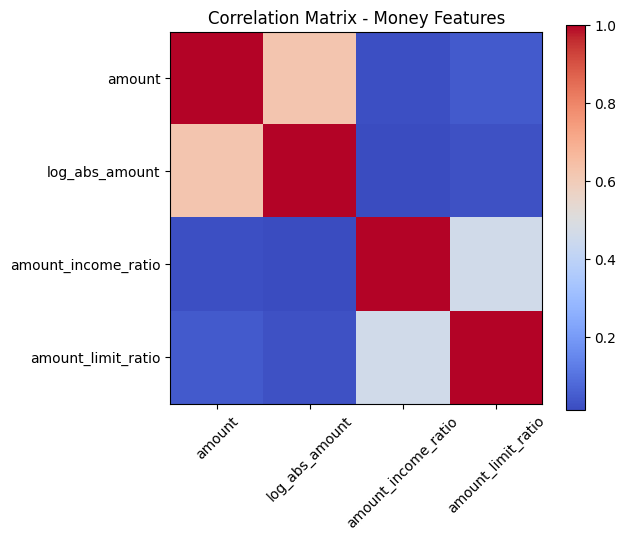

                       amount  log_abs_amount  amount_income_ratio  \
amount               1.000000        0.623983             0.022711   
log_abs_amount       0.623983        1.000000             0.012321   
amount_income_ratio  0.022711        0.012321             1.000000   
amount_limit_ratio   0.043767        0.024982             0.463054   

                     amount_limit_ratio  
amount                         0.043767  
log_abs_amount                 0.024982  
amount_income_ratio            0.463054  
amount_limit_ratio             1.000000  


In [73]:
corr = df[money_cols].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(money_cols)), money_cols, rotation=45)
plt.yticks(range(len(money_cols)), money_cols)
plt.title("Correlation Matrix - Money Features")
plt.show()

print(corr)

In [74]:
df["amount_limit_ratio"].describe()

count    6.096550e+05
mean     1.169890e+05
std      5.381430e+06
min     -4.860000e+08
25%      1.263398e-03
50%      2.725556e-03
75%      8.120810e-03
max      1.863290e+09
Name: amount_limit_ratio, dtype: float64

In [75]:
upper = df["amount_limit_ratio"].quantile(0.995)
lower = df["amount_limit_ratio"].quantile(0.005)

df_clip = df[
    (df["amount_limit_ratio"] < upper) &
    (df["amount_limit_ratio"] > lower)
]


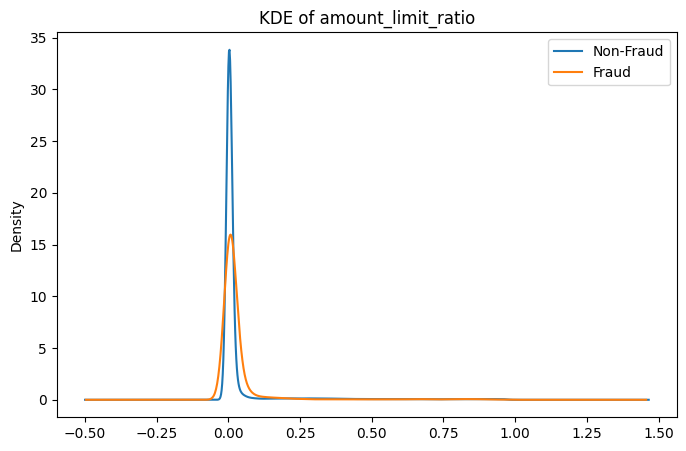

In [76]:
df_nf = df_clip[df_clip["fraud"] == 0]
df_f  = df_clip[df_clip["fraud"] == 1]

plt.figure(figsize=(8,5))
df_nf["amount_limit_ratio"].plot.kde(label="Non-Fraud")
df_f["amount_limit_ratio"].plot.kde(label="Fraud")

plt.legend()
plt.title("KDE of amount_limit_ratio")
plt.show()


---

## 3) 고객 인구통계/신용 프로필 (customer risk profile)

* `current_age`
* `male`
* `yearly_income`, `log_yearly_income`
* `per_capita_income`
* `income_ratio_region`, `log_income_ratio_region`
* `total_debt`
* `credit_score`

**분석 포인트**

* fraud가 특정 구간(저신용/고부채/저소득)에서 증가하는지
* income 원천 변수와 파생 변수(로그/비율) 중복/효용 비교
* demographic 변수는 **편향/해석 이슈**가 생길 수 있으니 영향이 크면 사용 목적을 명확히(성능 vs 정책)

---

In [77]:
money_cols = [
    "amount",
    "log_abs_amount",
    "amount_income_ratio",
    "amount_limit_ratio"
]

for col in money_cols:
    print(f"\n===== {col} =====")
    print(df[col].describe())
    print("Top 5 values:")
    print(df[col].sort_values(ascending=False).head())



===== amount =====
count    609655.000000
mean         57.315319
std          94.545731
min        -500.000000
25%          21.690001
50%          34.980000
75%          57.529999
max        5696.779785
Name: amount, dtype: float64
Top 5 values:
4230038    5696.779785
186887     4978.450195
782346     4266.209961
534711     4199.330078
3670250    3996.169922
Name: amount, dtype: float32

===== log_abs_amount =====
count    609655.000000
mean          3.647053
std           0.933710
min           0.000000
25%           3.134189
50%           3.592919
75%           4.086312
max           8.647832
Name: log_abs_amount, dtype: float64
Top 5 values:
4230038    8.647832
186887     8.513075
782346     8.358715
534711     8.342918
3670250    8.293342
Name: log_abs_amount, dtype: float32

===== amount_income_ratio =====
count    609655.000000
mean          0.016159
std           1.250431
min        -207.999802
25%           0.000452
50%           0.000787
75%           0.001499
max         621

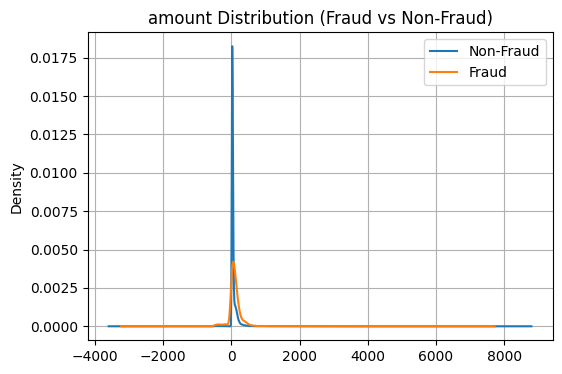

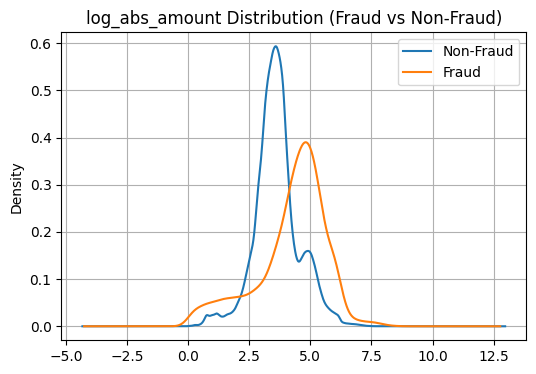

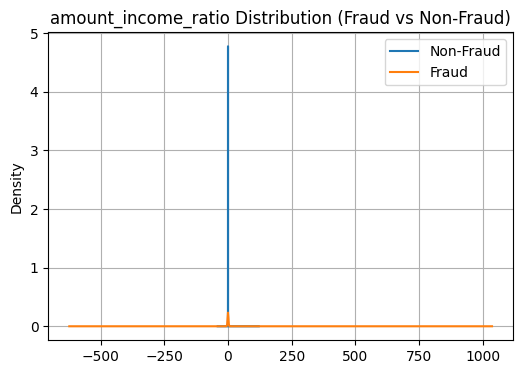

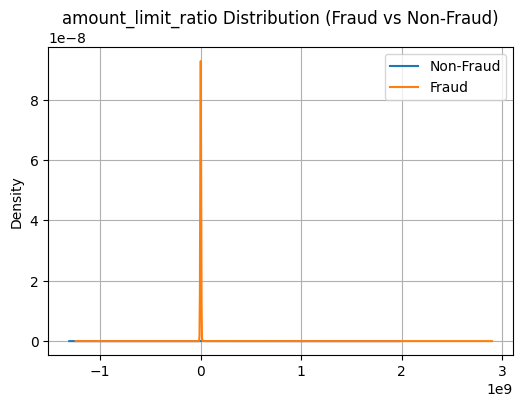

In [78]:
for col in money_cols:
    plt.figure(figsize=(6,4))
    
    df[df["fraud"] == 0][col].plot(kind="kde", label="Non-Fraud")
    df[df["fraud"] == 1][col].plot(kind="kde", label="Fraud")
    
    plt.title(f"{col} Distribution (Fraud vs Non-Fraud)")
    plt.legend()
    plt.grid(True)
    plt.show()


amount가 유의미한 차이

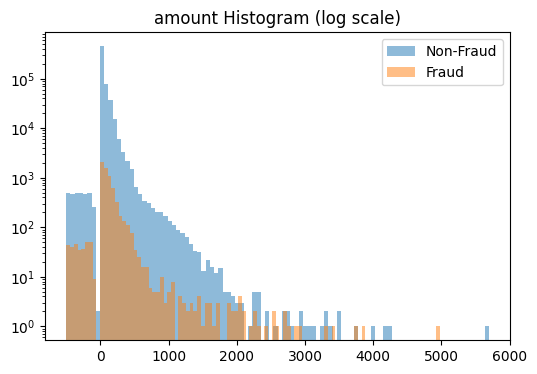

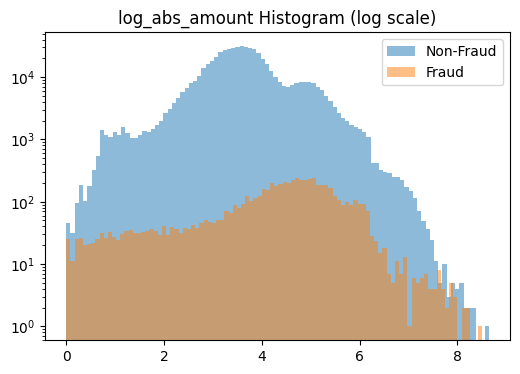

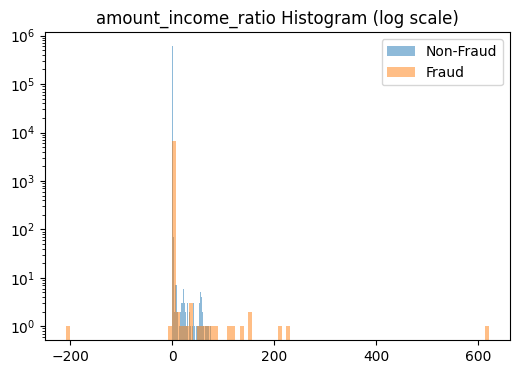

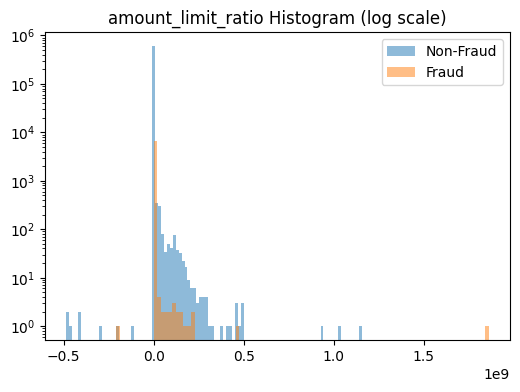

In [79]:
for col in money_cols:
    plt.figure(figsize=(6,4))
    
    plt.hist(df[df["fraud"]==0][col], bins=100, alpha=0.5, label="Non-Fraud")
    plt.hist(df[df["fraud"]==1][col], bins=100, alpha=0.5, label="Fraud")
    
    plt.yscale("log")
    plt.title(f"{col} Histogram (log scale)")
    plt.legend()
    plt.show()


In [80]:
for col in money_cols:
    print(f"\n===== Statistical Test: {col} =====")
    print(evaluate_numeric_feature(df, col))



===== Statistical Test: amount =====
KS_p               0.000000
MW_p               0.000000
Cohen_d            0.657115
Odds_Ratio         1.002283
Logit_p            0.000000
PR_AUC             0.030839
n             609655.000000
pos_rate           0.010823
dtype: float64

===== Statistical Test: log_abs_amount =====
KS_p               0.000000
MW_p               0.000000
Cohen_d            0.647072
Odds_Ratio         1.905734
Logit_p            0.000000
PR_AUC             0.034671
n             609655.000000
pos_rate           0.010823
dtype: float64

===== Statistical Test: amount_income_ratio =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       2.452971e-01
Odds_Ratio    1.039845e+00
Logit_p       4.200211e-18
PR_AUC        3.476515e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64

===== Statistical Test: amount_limit_ratio =====
KS_p           0.000000e+00
MW_p          6.891895e-251
Cohen_d        1.046532e-01
Odds_Ratio     1.00000

---

In [81]:
df.groupby(pd.qcut(df["amount_limit_ratio"], 10))["fraud"].mean()

/tmp/ipykernel_2467402/1337225554.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df["amount_limit_ratio"], 10))["fraud"].mean()


amount_limit_ratio
(-486000000.001, 0.000704]    0.016878
(0.000704, 0.00109]           0.003117
(0.00109, 0.00144]            0.002542
(0.00144, 0.00192]            0.002739
(0.00192, 0.00273]            0.005085
(0.00273, 0.00402]            0.008087
(0.00402, 0.00626]            0.011892
(0.00626, 0.0108]             0.015074
(0.0108, 0.034]               0.021258
(0.034, 1863289984.0]         0.021553
Name: fraud, dtype: float64

아주 낮은 ratio 구간 → fraud 높음 (1.6%)

상위 구간 → fraud 다시 높아짐 (2.1%)

In [82]:
df["low_ratio_flag"] = df["amount_limit_ratio"].quantile(0.05)
df["high_ratio_flag"] = df["amount_limit_ratio"].quantile(0.95)

In [83]:
evaluate_numeric_feature(df, "low_ratio_flag")

KS_p               1.000000
MW_p               1.000000
Cohen_d           -1.206281
Odds_Ratio         0.000000
Logit_p            0.000000
PR_AUC             0.010823
n             609655.000000
pos_rate           0.010823
dtype: float64

In [84]:
evaluate_numeric_feature(df, "high_ratio_flag")

KS_p          1.000000e+00
MW_p          1.000000e+00
Cohen_d                NaN
Odds_Ratio    9.430475e-07
Logit_p       0.000000e+00
PR_AUC        1.082251e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64

limit에 비해 지출이 극단적으로 크거나 작을 때 fraud일 확률이 높다

---

In [85]:
df.groupby(pd.qcut(df["amount_income_ratio"], 10))["fraud"].mean()

/tmp/ipykernel_2467402/89038327.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df["amount_income_ratio"], 10))["fraud"].mean()


amount_income_ratio
(-208.001, 0.000258]    0.018928
(0.000258, 0.000396]    0.003510
(0.000396, 0.000507]    0.002526
(0.000507, 0.000638]    0.002657
(0.000638, 0.000787]    0.003527
(0.000787, 0.001]       0.004298
(0.001, 0.0013]         0.006085
(0.0013, 0.00181]       0.010268
(0.00181, 0.00333]      0.021619
(0.00333, 621.096]      0.034806
Name: fraud, dtype: float64

In [86]:
q05 = df["amount_income_ratio"].quantile(0.05)
q95 = df["amount_income_ratio"].quantile(0.95)

df["low_income_flag"]  = df["amount_income_ratio"] < q05
df["high_income_flag"] = df["amount_income_ratio"] > q95

In [87]:
print("low_income_flag")
evaluate_numeric_feature(df, "low_income_flag")

low_income_flag


KS_p           6.348491e-54
MW_p          2.849375e-283
Cohen_d        4.456658e-01
Odds_Ratio     3.321247e+00
Logit_p       2.386639e-252
PR_AUC         1.385501e-02
n              6.096550e+05
pos_rate       1.082251e-02
dtype: float64

In [88]:
print("high_income_flag")
evaluate_numeric_feature(df, "high_income_flag")

high_income_flag


KS_p          9.702725e-159
MW_p           0.000000e+00
Cohen_d        7.666457e-01
Odds_Ratio     5.401024e+00
Logit_p        0.000000e+00
PR_AUC         1.848145e-02
n              6.096550e+05
pos_rate       1.082251e-02
dtype: float64

---

In [89]:
evaluate_numeric_feature(df, "total_debt")

KS_p          3.455596e-24
MW_p          1.469043e-21
Cohen_d      -1.186098e-01
Odds_Ratio    9.999974e-01
Logit_p       8.486342e-22
PR_AUC        1.224004e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64

In [90]:
evaluate_numeric_feature(df, "credit_score")

KS_p          3.678326e-23
MW_p          1.204664e-07
Cohen_d       6.870870e-02
Odds_Ratio    1.000980e+00
Logit_p       2.851233e-08
PR_AUC        1.099539e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64

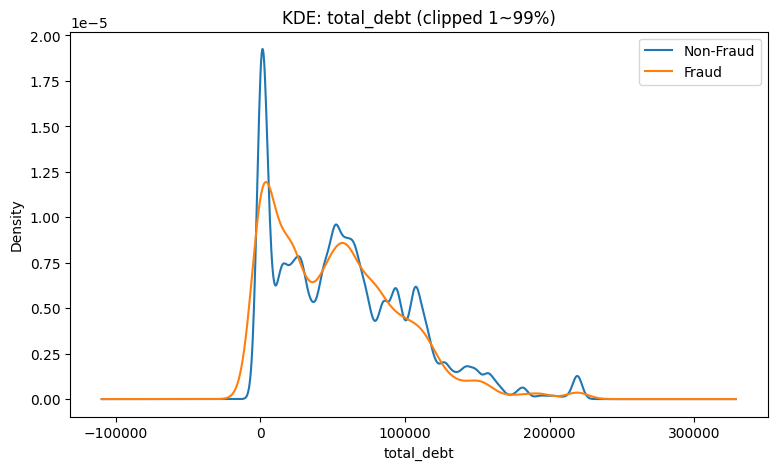

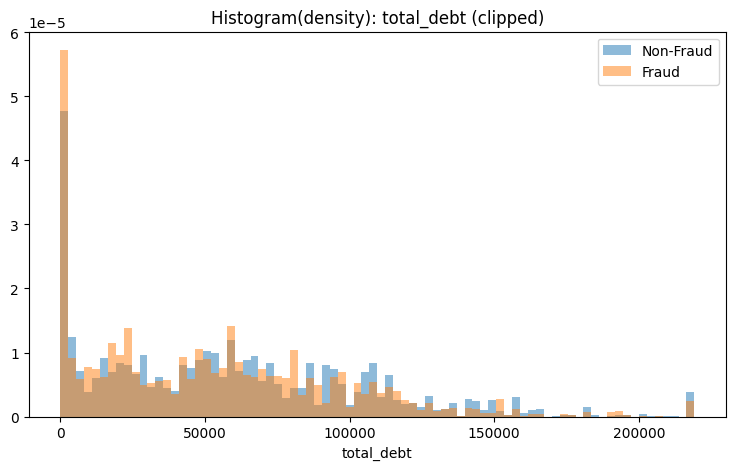

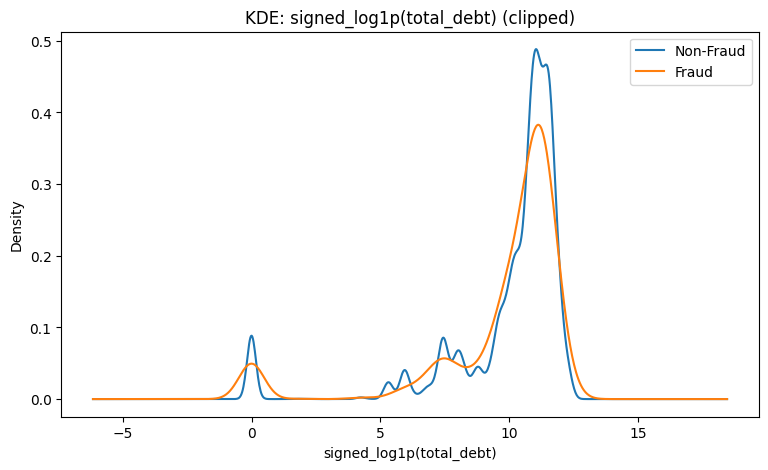

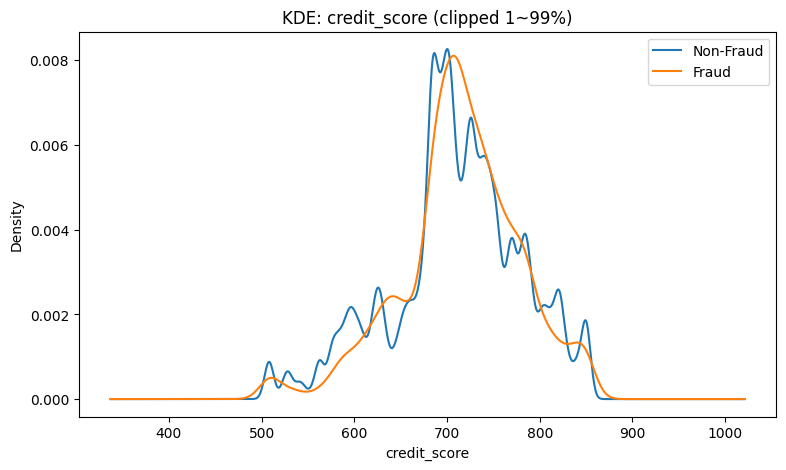

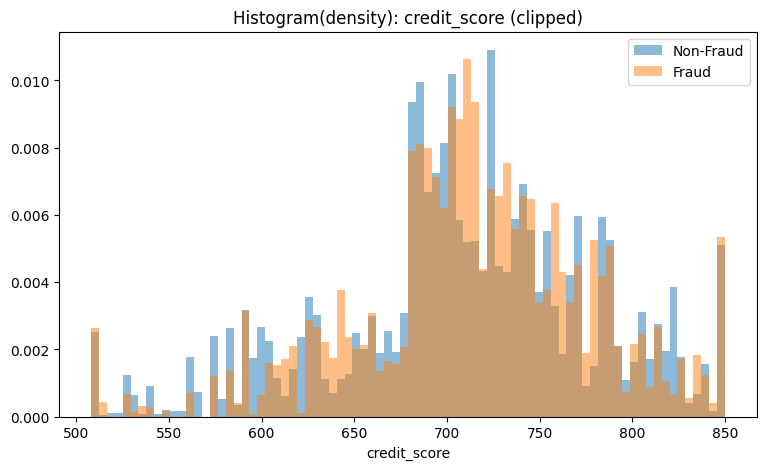

In [91]:
def plot_feature_eda(df, col, label_col="fraud", bins=80, clip_q=(0.01, 0.99), log_abs=False):

    s = df[col].astype("float64").replace([np.inf, -np.inf], np.nan).dropna()
    lo, hi = s.quantile(clip_q[0]), s.quantile(clip_q[1])

    df_nf = df[df[label_col] == 0].copy()
    df_f  = df[df[label_col] == 1].copy()

    # 클립 적용(시각화용)
    def _clip(x):
        x = x.astype("float64").replace([np.inf, -np.inf], np.nan).dropna()
        return x.clip(lo, hi)

    x_nf = _clip(df_nf[col])
    x_f  = _clip(df_f[col])

    # ---- 1) KDE
    plt.figure(figsize=(9,5))
    x_nf.plot.kde(label="Non-Fraud")
    x_f.plot.kde(label="Fraud")
    plt.title(f"KDE: {col} (clipped {clip_q[0]*100:.0f}~{clip_q[1]*100:.0f}%)")
    plt.xlabel(col)
    plt.legend()
    plt.show()

    # ---- 2) Histogram (density)
    plt.figure(figsize=(9,5))
    plt.hist(x_nf, bins=bins, density=True, alpha=0.5, label="Non-Fraud")
    plt.hist(x_f,  bins=bins, density=True, alpha=0.5, label="Fraud")
    plt.title(f"Histogram(density): {col} (clipped)")
    plt.xlabel(col)
    plt.legend()
    plt.show()

    # ---- 3) Optional: signed log transform plots
    if log_abs:
        def slog1p(x):
            x = x.astype("float64").replace([np.inf, -np.inf], np.nan).dropna()
            return np.sign(x) * np.log1p(np.abs(x))

        x_nf2 = slog1p(df_nf[col])
        x_f2  = slog1p(df_f[col])

        s2 = np.concatenate([x_nf2.values, x_f2.values])
        lo2, hi2 = np.quantile(s2, clip_q[0]), np.quantile(s2, clip_q[1])
        x_nf2 = x_nf2.clip(lo2, hi2)
        x_f2  = x_f2.clip(lo2, hi2)

        plt.figure(figsize=(9,5))
        x_nf2.plot.kde(label="Non-Fraud")
        x_f2.plot.kde(label="Fraud")
        plt.title(f"KDE: signed_log1p({col}) (clipped)")
        plt.xlabel(f"signed_log1p({col})")
        plt.legend()
        plt.show()


plot_feature_eda(df, "total_debt", label_col="fraud", clip_q=(0.01, 0.99), log_abs=True)
plot_feature_eda(df, "credit_score", label_col="fraud", clip_q=(0.01, 0.99), log_abs=False)


사기(Fraud)는 보통:

고객의 신용 수준 때문이 아니라

계정 탈취 / 카드 탈취 / 결제 환경 이상

같은 행동 기반 이벤트

---

## 4) 카드/계정 상태(카드 생애주기 + 보안 이벤트)

* `num_cards_issued`
* `num_credit_cards`
* `credit_limit`
* `has_chip`
* `year_pin_last_changed`
* `years_since_pin_change`
* `months_to_expire`

**분석 포인트**

* PIN 변경 직후/오래된 PIN이 위험 신호인지
* 만료 임박(months_to_expire)이 fraud에 연결되는지
* chip 유무, 카드 발급 수가 어떤 의미인지(사기 시나리오 해석)
* “한도/소득/부채” 조합으로 risk profile 강화 가능

---


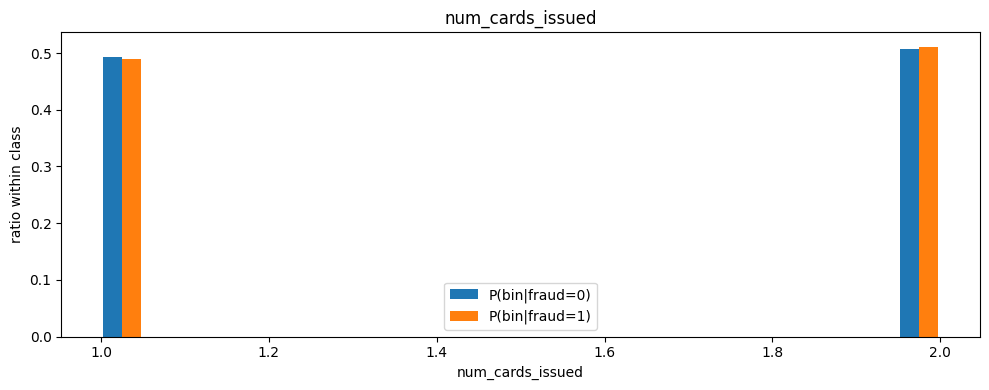

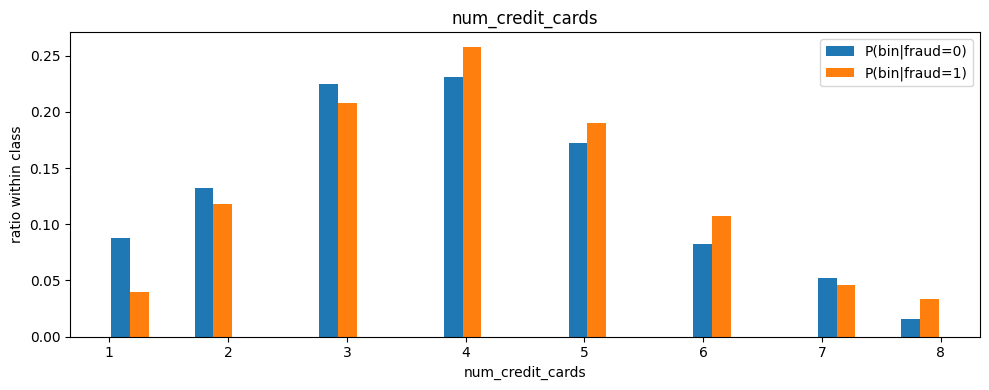

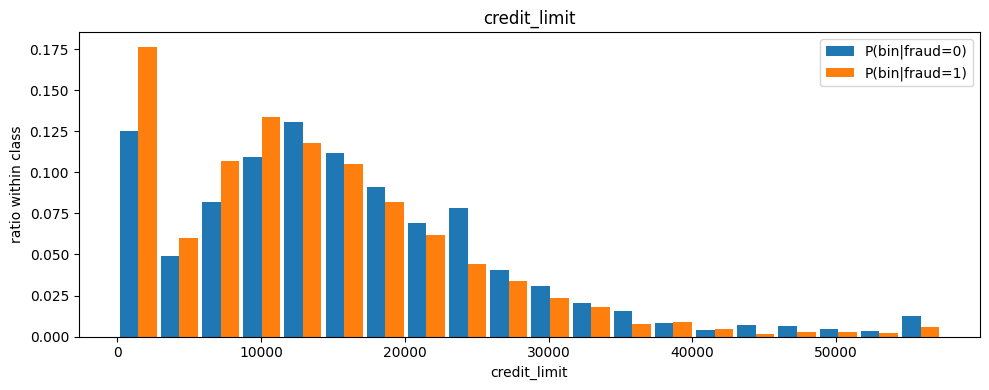

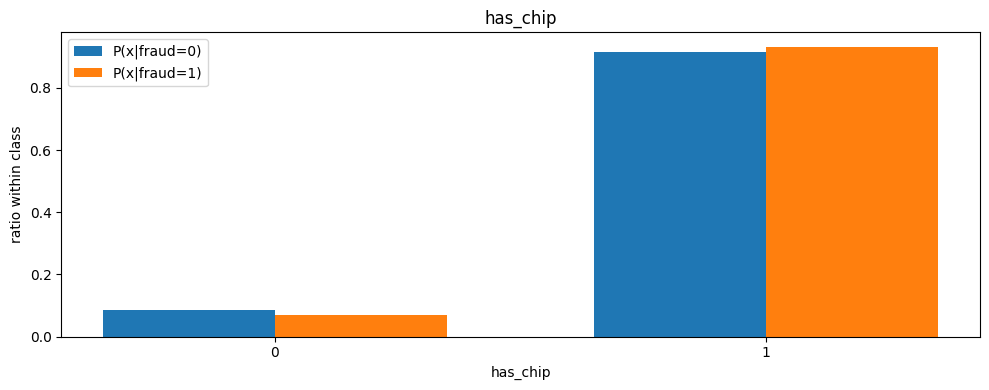

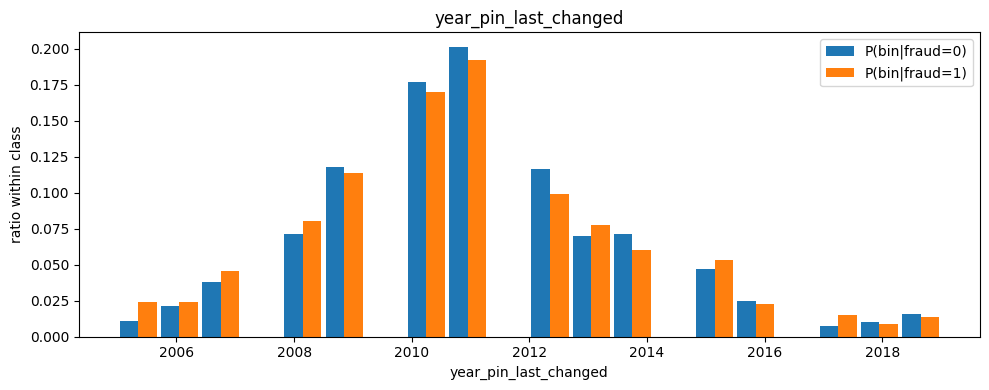

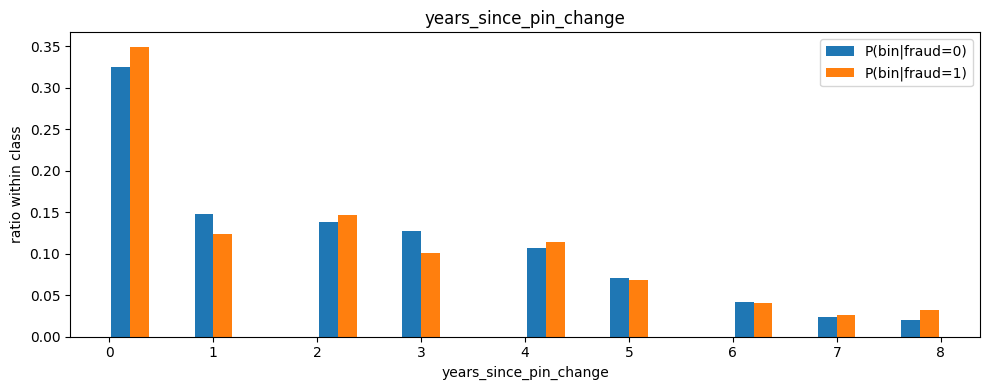

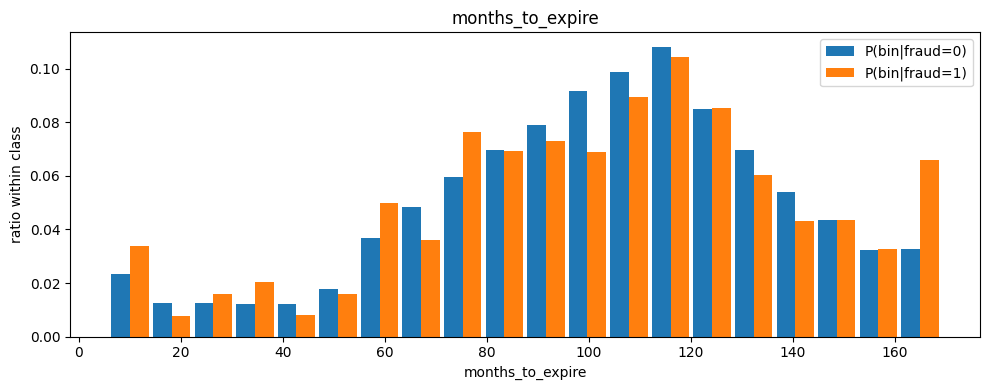

In [92]:
FEATURES = [
    "num_cards_issued",
    "num_credit_cards",
    "credit_limit",
    "has_chip",
    "year_pin_last_changed",
    "years_since_pin_change",
    "months_to_expire",
]
LABEL_COL = "fraud"  # 0/1

def _to_numeric_safe(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _is_binary_like(s: pd.Series) -> bool:
    x = s.dropna()
    if x.empty:
        return False
    if x.dtype == bool:
        return True
    xn = pd.to_numeric(x, errors="coerce")
    if xn.notna().all():
        return set(np.unique(xn.values)).issubset({0, 1})
    xu = set(map(lambda v: str(v).strip().lower(), np.unique(x.astype(str).values)))
    known = {"0", "1", "true", "false", "yes", "no", "y", "n", "t", "f"}
    return xu.issubset(known)

def _binary_normalize(s: pd.Series) -> pd.Series:
    if s.dtype == bool:
        return s.astype(float)
    sn = pd.to_numeric(s, errors="coerce")
    if sn.notna().all():
        return sn.astype(float)
    mapper = {
        "1": 1, "0": 0,
        "true": 1, "false": 0,
        "yes": 1, "no": 0,
        "y": 1, "n": 0,
        "t": 1, "f": 0,
    }
    return s.astype(str).str.strip().str.lower().map(mapper).astype(float)

def plot_class_ratio_only(
    df: pd.DataFrame,
    col: str,
    label_col: str = LABEL_COL,
    bins: int = 20,
    clip_q=(0.01, 0.99),
    min_bin_count: int = 30,
):
    if col not in df.columns:
        raise KeyError(f"Missing feature column: {col}")
    if label_col not in df.columns:
        raise KeyError(f"Missing label column: {label_col}")

    s = df[col]
    is_bin = _is_binary_like(s)

    plt.figure(figsize=(10, 4))

    if is_bin:
        tmp = df[[col, label_col]].copy()
        tmp[col] = _binary_normalize(tmp[col])

        g0 = tmp.loc[tmp[label_col] == 0, col]
        g1 = tmp.loc[tmp[label_col] == 1, col]

        cats = [0.0, 1.0]
        x = np.arange(len(cats))
        w = 0.35

        v0 = g0.value_counts(dropna=True).reindex(cats).fillna(0.0).values
        v1 = g1.value_counts(dropna=True).reindex(cats).fillna(0.0).values
        v0 = v0 / max(v0.sum(), 1e-12)
        v1 = v1 / max(v1.sum(), 1e-12)

        plt.bar(x - w / 2, v0, width=w, label="P(x|fraud=0)")
        plt.bar(x + w / 2, v1, width=w, label="P(x|fraud=1)")
        plt.xticks(x, ["0", "1"])
        plt.xlabel(col)
        plt.ylabel("ratio within class")
        plt.title(col)
        plt.legend()

    else:
        sn = _to_numeric_safe(s)
        if sn.dropna().empty:
            plt.title(f"{col} (no numeric values)")
            plt.show()
            return

        ql, qh = sn.quantile(list(clip_q))

        x_all = _to_numeric_safe(df[col]).clip(lower=ql, upper=qh)
        x0 = _to_numeric_safe(df.loc[df[label_col] == 0, col]).clip(lower=ql, upper=qh)
        x1 = _to_numeric_safe(df.loc[df[label_col] == 1, col]).clip(lower=ql, upper=qh)

        edges = np.histogram_bin_edges(x_all.dropna().values, bins=bins)
        centers = (edges[:-1] + edges[1:]) / 2
        bin_w = (edges[1] - edges[0])
        w = bin_w * 0.45

        c0, _ = np.histogram(x0.dropna().values, bins=edges)
        c1, _ = np.histogram(x1.dropna().values, bins=edges)

        c_all = c0 + c1
        mask = c_all >= min_bin_count

        r0 = c0.astype(float)
        r1 = c1.astype(float)
        r0 = r0 / max(r0.sum(), 1e-12)
        r1 = r1 / max(r1.sum(), 1e-12)

        plt.bar(centers[mask] - w / 2, r0[mask], width=w, label="P(bin|fraud=0)")
        plt.bar(centers[mask] + w / 2, r1[mask], width=w, label="P(bin|fraud=1)")
        plt.xlabel(col)
        plt.ylabel("ratio within class")
        plt.title(col)
        plt.legend()

    plt.tight_layout()
    plt.show()

missing_cols = [c for c in FEATURES + [LABEL_COL] if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns in df: {missing_cols}")

for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [93]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[num_cards_issued]
KS_p               0.985882
MW_p               0.242786
Cohen_d            0.019706
Odds_Ratio         1.039454
Logit_p            0.111406
PR_AUC             0.011001
n             609655.000000
pos_rate           0.010823
dtype: float64


[num_credit_cards]
KS_p          1.162872e-36
MW_p          1.330333e-48
Cohen_d       1.889365e-01
Odds_Ratio    1.117905e+00
Logit_p       1.975195e-52
PR_AUC        1.272678e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64


[credit_limit]
KS_p          3.760083e-86
MW_p          1.366146e-89
Cohen_d      -2.202549e-01
Odds_Ratio    9.999779e-01
Logit_p       8.136305e-73
PR_AUC        1.431145e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64


[has_chip]
KS_p          2.722484e-02
MW_p          1.778273e-07
Cohen_d       6.462956e-02
Odds_Ratio    1.291326e+00
Logit_p       1.918509e-07
PR_AUC        1.102026e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float6

- 한도가 낮은 카드에서 fraud 비율이 상대적으로 높다

---

## 5) 거래 채널/거래 성격(온라인 vs 오프라인 + 결제 타입)

* `is_online` 
* `is_credit`
* `is_prepaid`

**분석 포인트**

* 채널별 base rate 차이(online/offline에 따라 사기 메커니즘 다름)
* prepaid가 사기/오류와 같이 움직이는지
* credit/prepaid 상호작용(온라인에서 특히 강해질 수 있음)

---

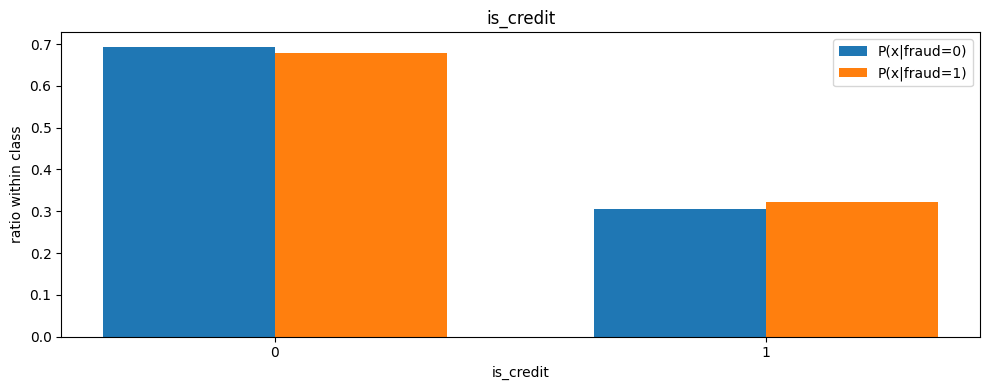

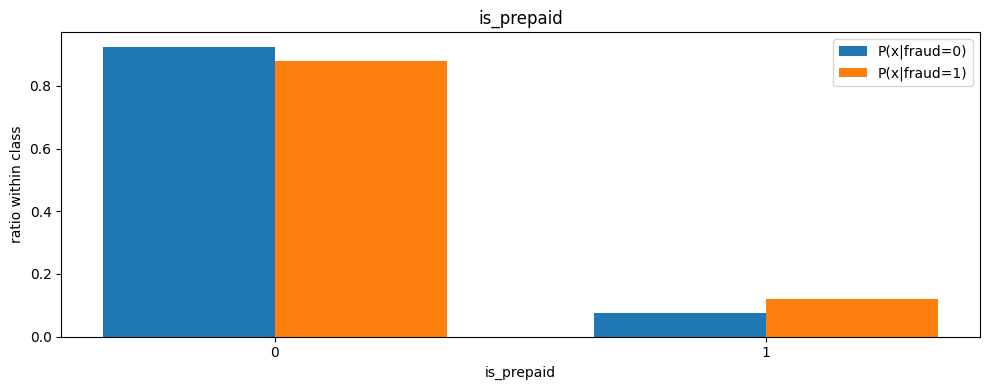

In [94]:
FEATURES = ["is_credit",
            "is_prepaid"]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)

In [95]:
df.drop("is_online",axis=1, inplace=True)

In [96]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[is_credit]
KS_p               0.095109
MW_p               0.007548
Cohen_d            0.033070
Odds_Ratio         1.073352
Logit_p            0.007560
PR_AUC             0.010994
n             609655.000000
pos_rate           0.010823
dtype: float64


[is_prepaid]
KS_p          1.167040e-11
MW_p          5.124466e-42
Cohen_d       1.681451e-01
Odds_Ratio    1.671468e+00
Logit_p       3.730405e-41
PR_AUC        1.157533e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64





---

## 6) 거래 오류/거절 이벤트(Authorization 실패 신호)

* `has_error`
* `err_bad_card_number`
* `err_bad_expiration`
* `err_bad_cvv`
* `err_bad_pin`
* `err_bad_zipcode`
* `err_insufficient_balance`
* `err_technical_glitch`

**분석 포인트**

* fraud에서 error가 **선행 신호**인지(사도 시도→승인 패턴)
* error type 별로 fraud 상승이 있는지
* `has_error`와 개별 err_*는 중복(계층구조) → 어떤 레벨로 쓸지 결정

---


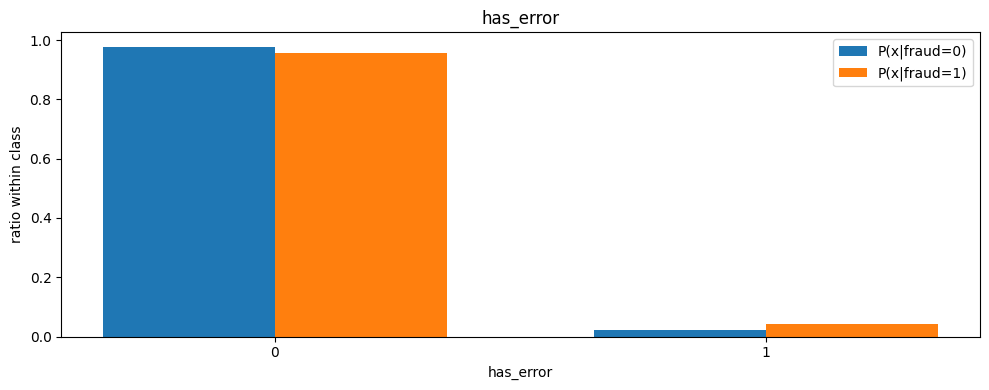

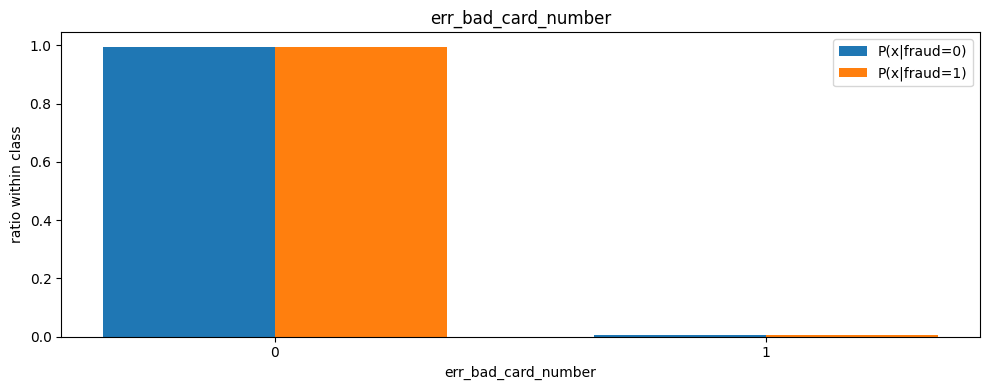

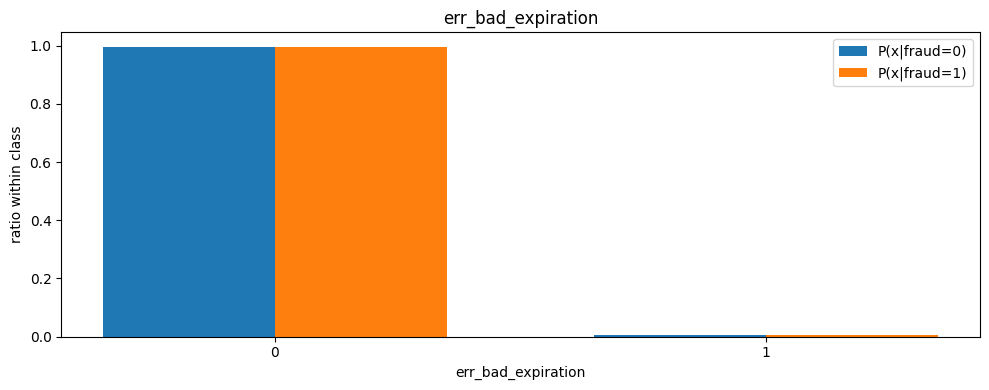

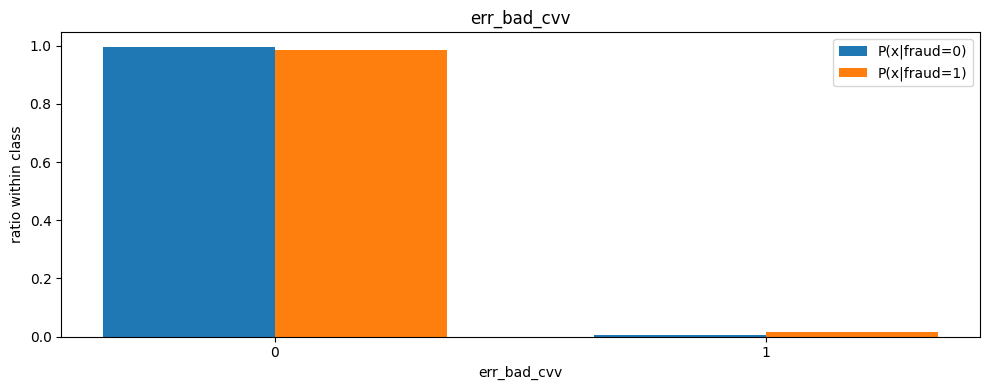

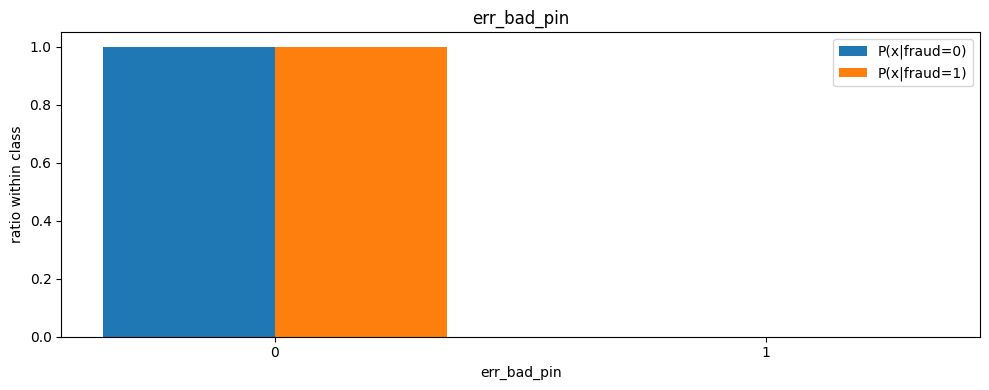

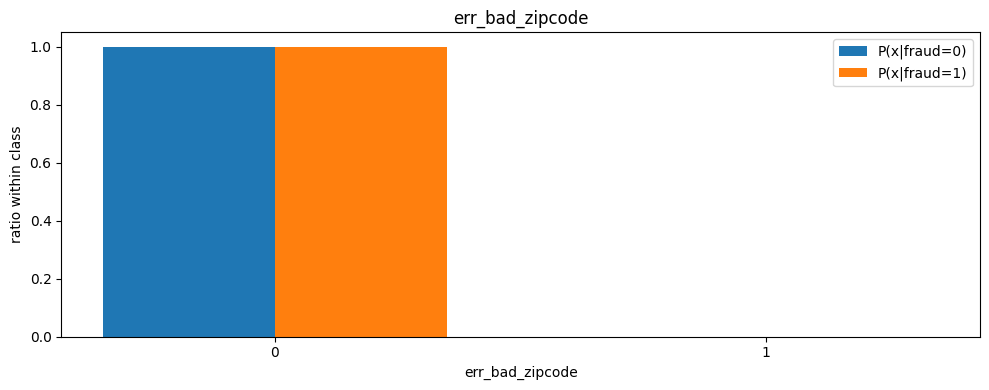

In [99]:
FEATURES = ["has_error",
  "err_bad_card_number",
  "err_bad_expiration",
  "err_bad_cvv",
  "err_bad_pin",
  "err_bad_zipcode",]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [100]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[has_error]
KS_p          5.124300e-03
MW_p          1.141573e-30
Cohen_d       1.425188e-01
Odds_Ratio    1.981891e+00
Logit_p       1.432746e-29
PR_AUC        1.126121e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64


[err_bad_card_number]
KS_p               1.000000
MW_p               0.039984
Cohen_d            0.025424
Odds_Ratio         1.356559
Logit_p            0.040758
PR_AUC             0.010849
n             609655.000000
pos_rate           0.010823
dtype: float64


[err_bad_expiration]
KS_p               1.000000
MW_p               0.080209
Cohen_d            0.021655
Odds_Ratio         1.341055
Logit_p            0.081295
PR_AUC             0.010842
n             609655.000000
pos_rate           0.010823
dtype: float64


[err_bad_cvv]
KS_p          2.724979e-01
MW_p          1.091743e-55
Cohen_d       1.946325e-01
Odds_Ratio    4.217336e+00
Logit_p       2.712974e-47
PR_AUC        1.135382e-02
n             6.096550e+05
pos_rate      1.082251e-02


| 변수              | 해석           |
| --------------- | ------------ |
| has_error       | 에러 자체는 위험 신호 |
| bad_cvv         | 매우 강한 위험 신호  |
| bad_card_number | 약한 위험 신호     |
| bad_expiration  | 약한 위험 신호     |
| bad_pin/zipcode | 무의미          |


---

## 7) 시간 특성(시계열/행동 루틴)

* `tx_year`
* `tx_month`
* `tx_day`
* `tx_hour`
* `is_weekend`

**분석 포인트**

* fraud가 특정 시간대/요일/월에 몰리는지
* 연도별 drift (특히 너 데이터는 2017~2018 fraud=0 이슈 있었지)
* 단순 time feature 자체가 “연도 레이블”처럼 작동할 위험(데이터 생성/라벨링 편향)

---


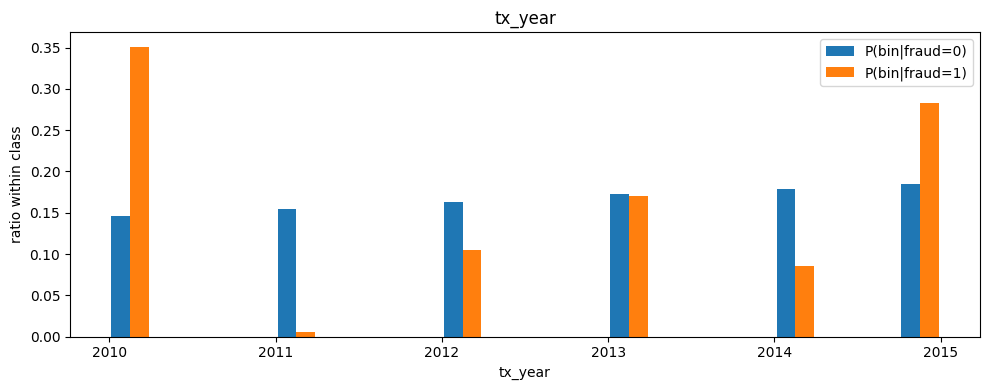

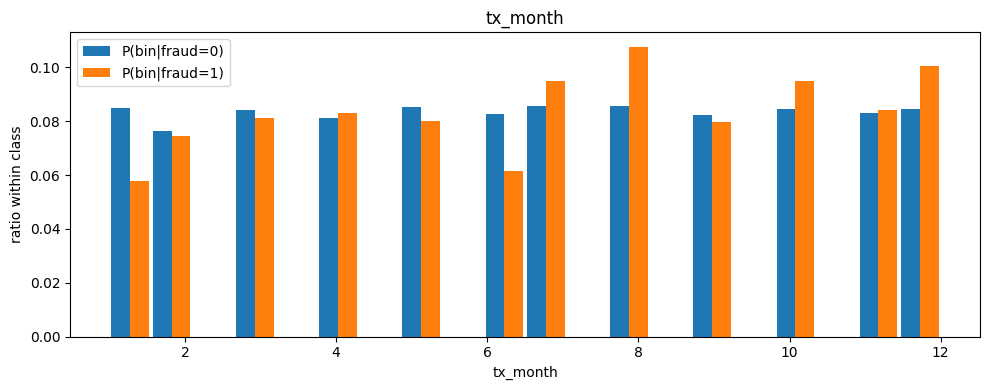

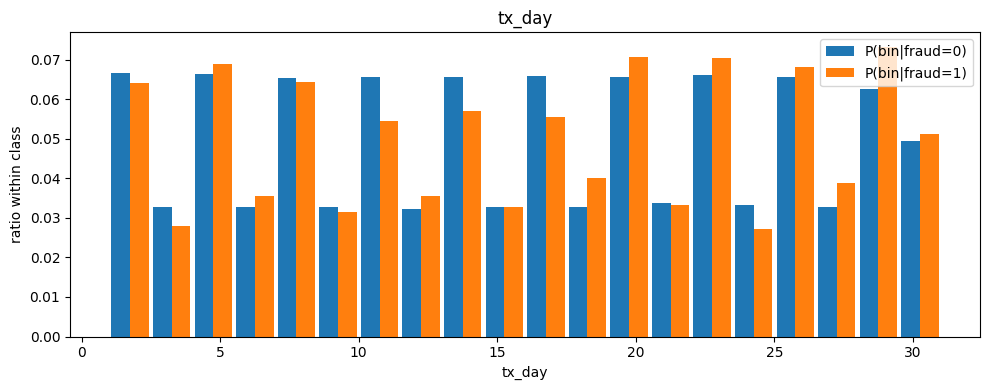

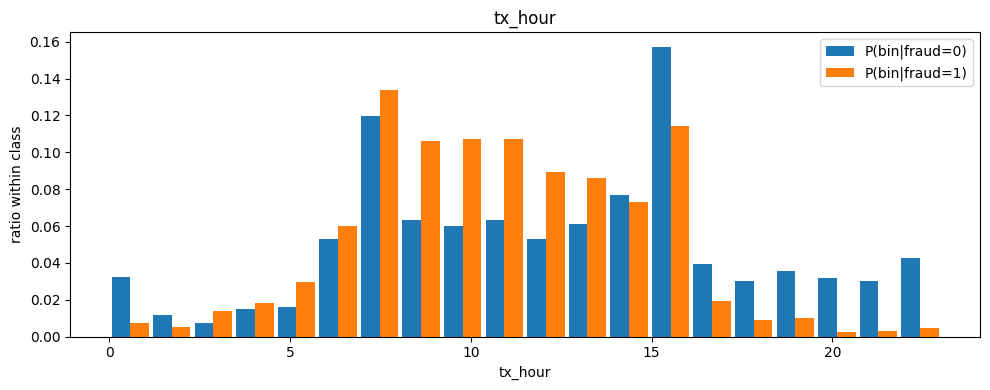

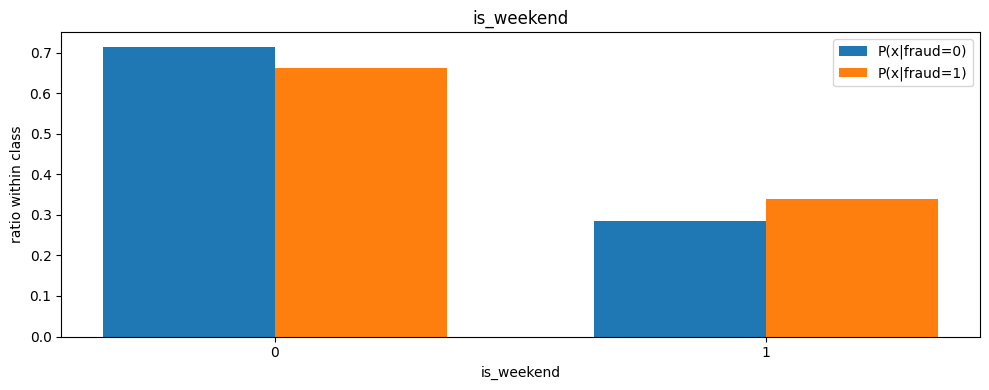

In [105]:
FEATURES = ["tx_year",
  "tx_month",
  "tx_day",
  "tx_hour",
  "is_weekend"]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [106]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[tx_year]
KS_p          1.563508e-242
MW_p           1.871666e-09
Cohen_d       -9.344568e-02
Odds_Ratio     9.467382e-01
Logit_p        4.625973e-14
PR_AUC         1.594129e-02
n              6.096550e+05
pos_rate       1.082251e-02
dtype: float64


[tx_month]
KS_p          2.809612e-18
MW_p          1.862011e-15
Cohen_d       9.858838e-02
Odds_Ratio    1.029122e+00
Logit_p       1.768427e-15
PR_AUC        1.169695e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64


[tx_day]
KS_p               0.000006
MW_p               0.000431
Cohen_d            0.043564
Odds_Ratio         1.004962
Logit_p            0.000434
PR_AUC             0.011327
n             609655.000000
pos_rate           0.010823
dtype: float64


[tx_hour]
KS_p          4.864311e-248
MW_p          1.385844e-165
Cohen_d       -3.030909e-01
Odds_Ratio     9.449756e-01
Logit_p       3.245283e-131
PR_AUC         1.276709e-02
n              6.096550e+05
pos_rate       1.082251e-02
dtype: float64


[is_


---

## 8) 업종/상점 카테고리(MCC Group one-hot)

* `mccg_Food_Daily`
* `mccg_Transport_Travel`
* `mccg_Digital_Online`
* `mccg_Financial`
* `mccg_Retail`
* `mccg_Medical`
* `mccg_Entertainment`
* `mccg_Automotive_Home`
* `mccg_Utilities_Government`
* `mccg_Professional_Services`
* `mccg_Industrial_/_Manufacturing`

**분석 포인트**

* 어떤 카테고리에서 base rate가 높은지
* 온라인 결제(`is_online`)와 결합될 때 상승하는 카테고리(상호작용)
* one-hot 다중공선성(기준 카테고리 빠졌는지 확인)

---

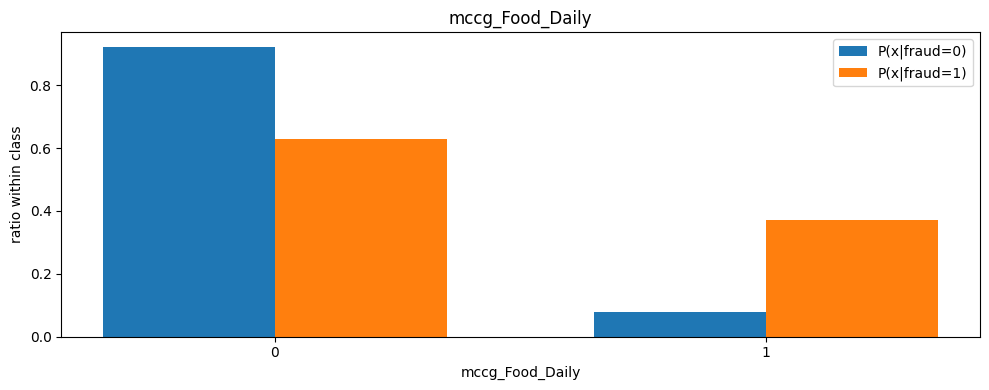

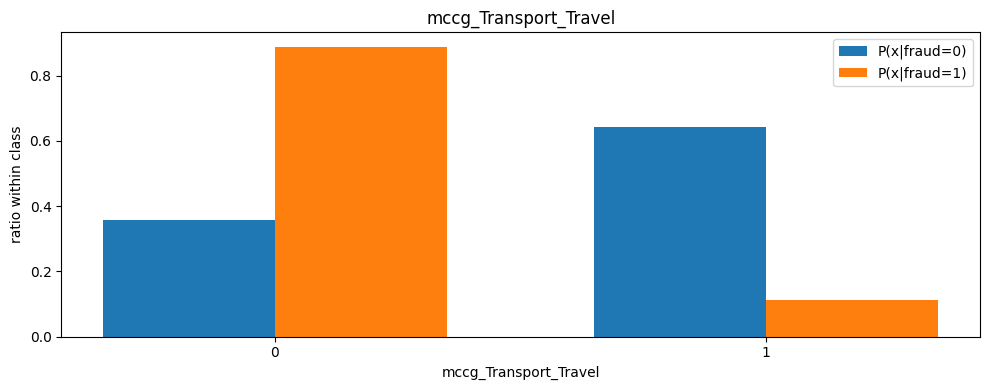

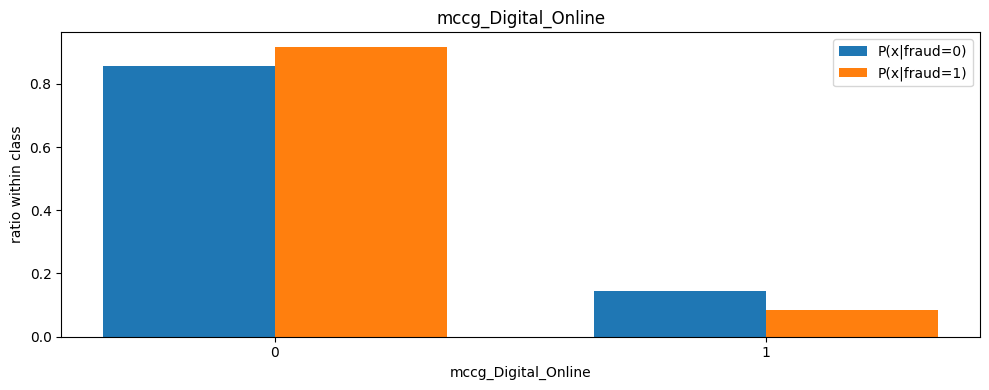

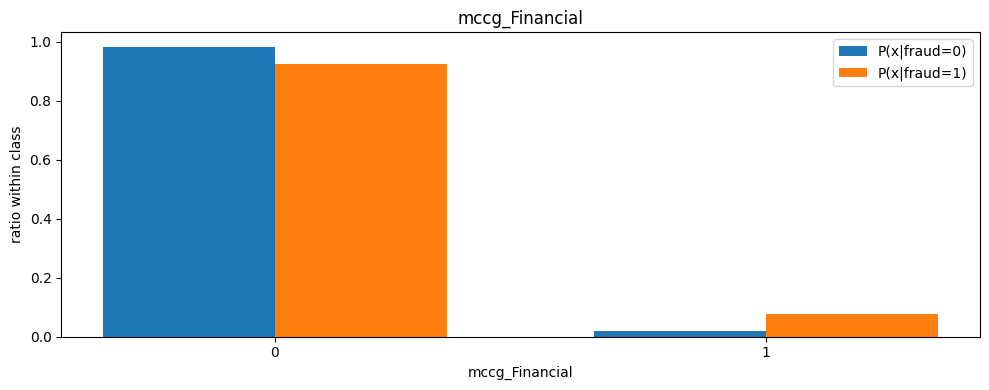

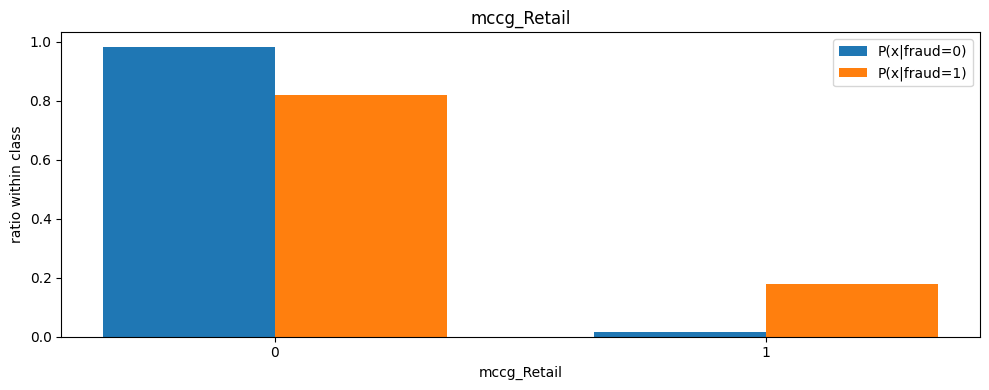

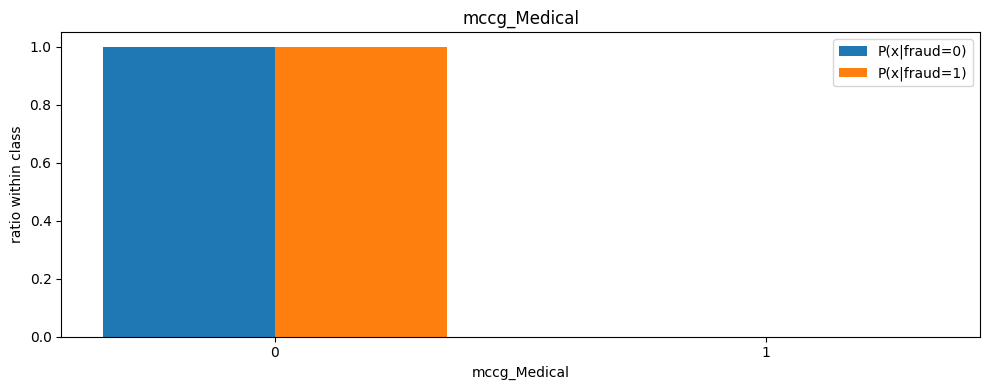

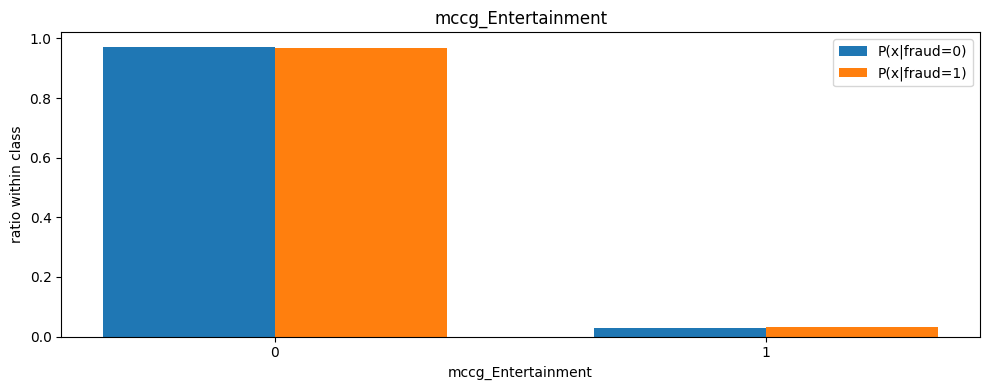

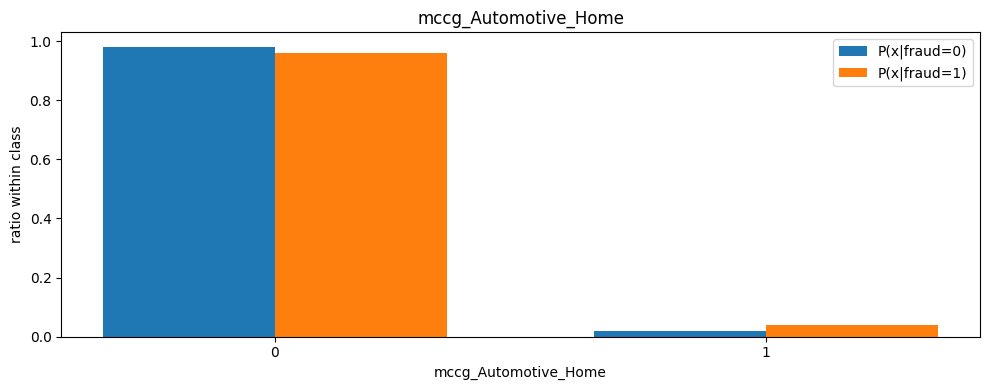

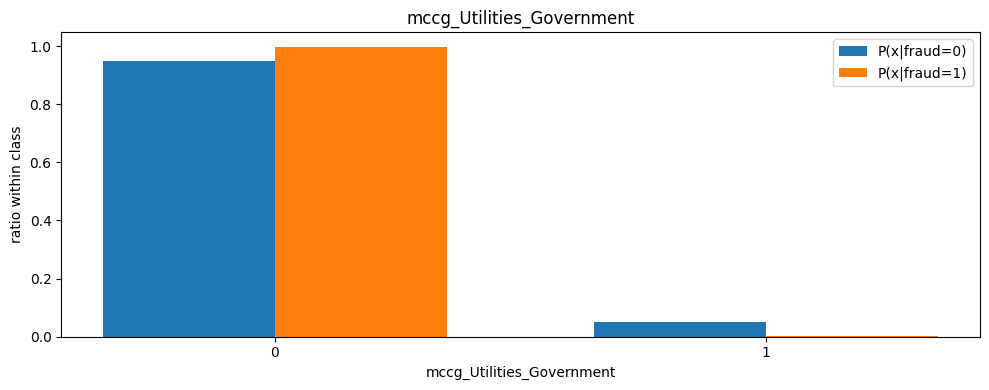

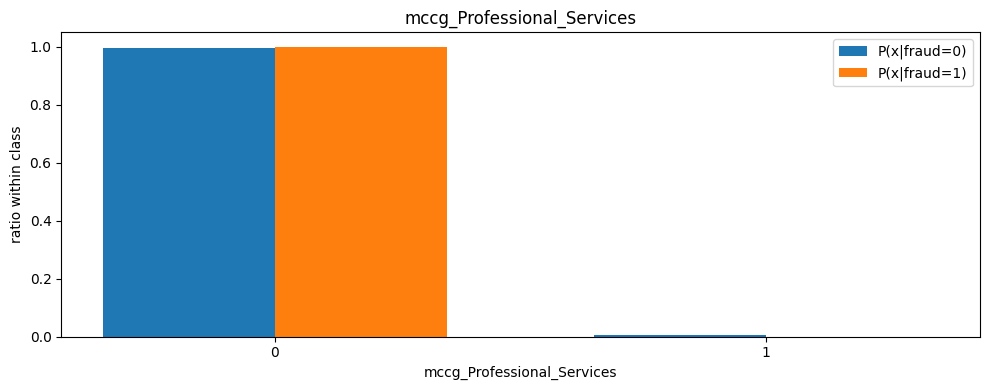

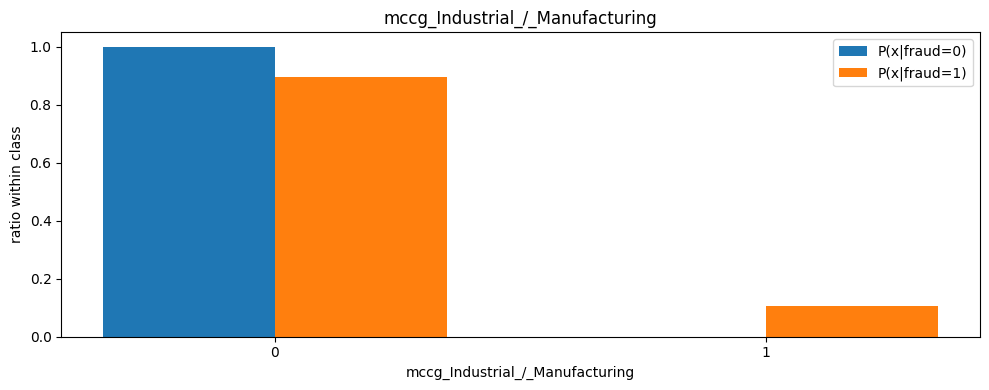

In [107]:
FEATURES = ["mccg_Food_Daily",
"mccg_Transport_Travel",
"mccg_Digital_Online",
"mccg_Financial",
"mccg_Retail",
"mccg_Medical",
"mccg_Entertainment",
"mccg_Automotive_Home",
"mccg_Utilities_Government",
"mccg_Professional_Services",
"mccg_Industrial_/_Manufacturing"]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [108]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[mccg_Food_Daily]
KS_p               0.000000
MW_p               0.000000
Cohen_d            1.088365
Odds_Ratio         7.054591
Logit_p            0.000000
PR_AUC             0.025363
n             609655.000000
pos_rate           0.010823
dtype: float64


[mccg_Transport_Travel]
KS_p               0.000000
MW_p               0.000000
Cohen_d           -1.108233
Odds_Ratio         0.070195
Logit_p            0.000000
PR_AUC             0.024655
n             609655.000000
pos_rate           0.010823
dtype: float64


[mccg_Digital_Online]
KS_p          4.801755e-22
MW_p          9.088552e-46
Cohen_d      -1.758060e-01
Odds_Ratio    5.347344e-01
Logit_p       2.257674e-44
PR_AUC        1.153016e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64


[mccg_Financial]
KS_p           1.329838e-19
MW_p          2.849634e-273
Cohen_d        4.376506e-01
Odds_Ratio     4.620221e+00
Logit_p       1.787468e-226
PR_AUC         1.343238e-02
n              6.096550e+05
pos_rate

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          9.995223e-01
MW_p          6.353706e-08
Cohen_d      -6.694955e-02
Odds_Ratio    1.417344e-08
Logit_p       9.907154e-01
PR_AUC        1.086998e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64


[mccg_Industrial_/_Manufacturing]
KS_p          3.773248e-63
MW_p          0.000000e+00
Cohen_d       3.293001e+00
Odds_Ratio             NaN
Logit_p                NaN
PR_AUC        1.147176e-01
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64




| MCC Group                      | Risk Level | Odds Ratio | Cohen’s d | PR-AUC     | 해석                        |
| ------------------------------ | ---------- | ---------- | --------- | ---------- | ------------------------- |
| **Retail**                     | 매우 높음   | **12.69**  | 1.21      | 0.0275     | 강력한 fraud 군집. 핵심 위험 카테고리  |
| **Food_Daily**                 | 매우 높음   | **7.05**   | 1.09      | 0.0254     | 일상 소비 카테고리에서 fraud 집중     |
| **Financial**                  | 높음      | **4.62**   | 0.44      | 0.0134     | 금융 관련 거래에서 fraud 과대표      |
| **Industrial / Manufacturing** | 극단적     | NaN (분리)   | **3.29**  | **0.1147** | 거의 완전 분리 수준. 데이터 구조 점검 필요 |
| **Automotive_Home**            | 중간       | 2.11       | 0.15      | 0.0113     | 약한 위험 신호                  |
| **Entertainment**              | 약함         | 1.19       | 0.03      | 0.0109     | 거의 무시 가능                  |


---

## 9) 카드 브랜드(결제 네트워크)

* `cb_Visa`
* `cb_Mastercard`
* `cb_Amex`
* `cb_Discover`

**분석 포인트**

* 브랜드별 base rate 차이(실제 의미일 수도, 데이터 생성 특성일 수도)
* 브랜드와 금액/업종/온라인 간 상호작용 가능

---

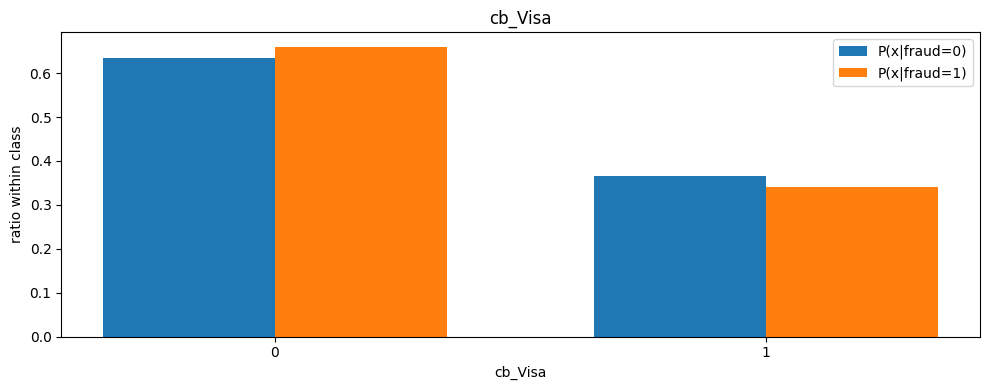

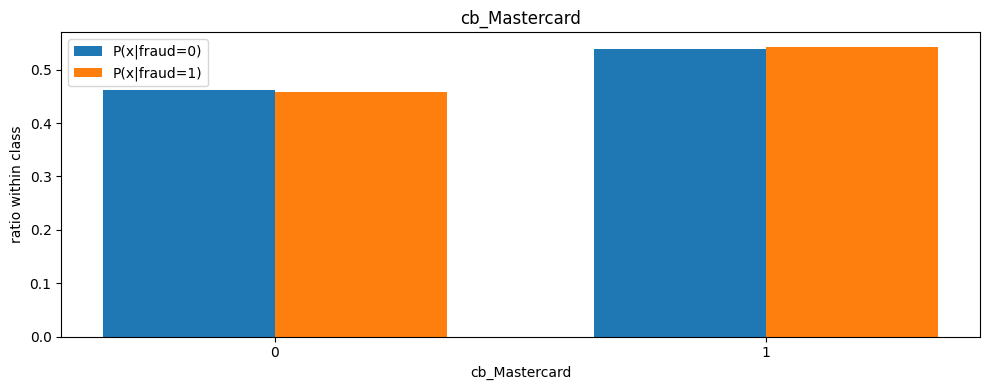

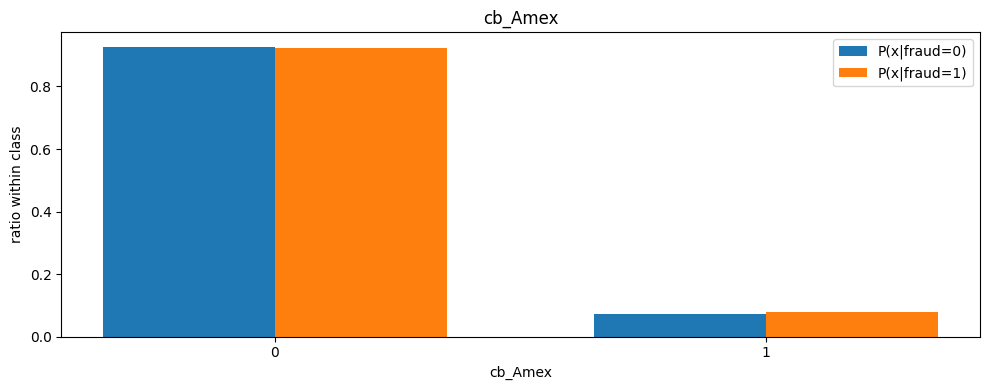

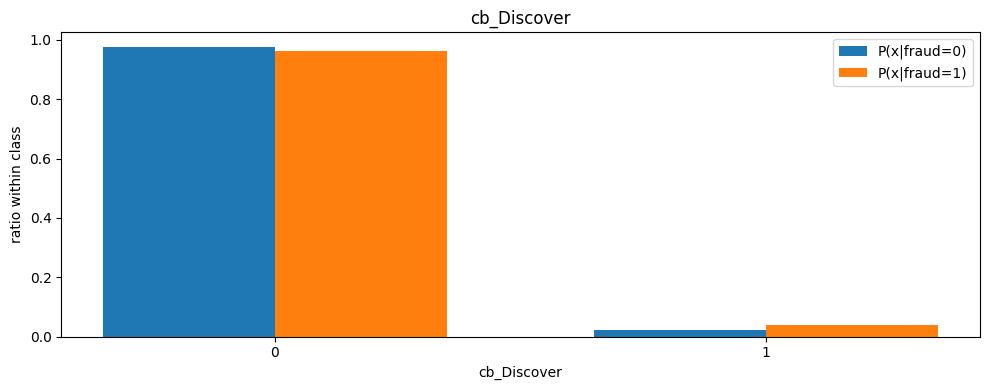

In [109]:
FEATURES = [
  "cb_Visa",
  "cb_Mastercard",
  "cb_Amex",
  "cb_Discover",]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [110]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[cb_Visa]
KS_p               0.000700
MW_p               0.000035
Cohen_d           -0.051245
Odds_Ratio         0.897538
Logit_p            0.000035
PR_AUC             0.011097
n             609655.000000
pos_rate           0.010823
dtype: float64


[cb_Mastercard]
KS_p               0.999658
MW_p               0.482357
Cohen_d            0.008696
Odds_Ratio         1.017609
Logit_p            0.482362
PR_AUC             0.010869
n             609655.000000
pos_rate           0.010823
dtype: float64


[cb_Amex]
KS_p               0.997201
MW_p               0.126587
Cohen_d            0.018910
Odds_Ratio         1.073047
Logit_p            0.126664
PR_AUC             0.010879
n             609655.000000
pos_rate           0.010823
dtype: float64


[cb_Discover]
KS_p          8.940614e-02
MW_p          3.549565e-16
Cohen_d       1.009249e-01
Odds_Ratio    1.676407e+00
Logit_p       7.414930e-16
PR_AUC        1.109269e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: floa

---

## 10) 위치 기반(거래 위치 vs 거주지)

* `distance_from_home`

**분석 포인트**

* 거리 분포(0 근처 mass vs 장거리 tail)
* fraud에서 장거리/이상 이동이 증가하는지
* 금액/시간과 상호작용(야간 + 장거리 + 온라인/오프라인 등)

---



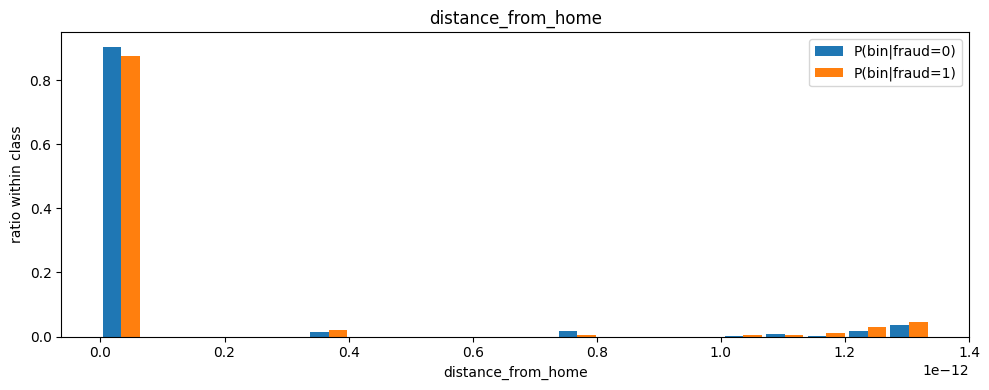

In [101]:
plot_class_ratio_only(df, "distance_from_home", LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [97]:
evaluate_numeric_feature(df, "distance_from_home")

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          7.410627e-07
MW_p          8.356106e-16
Cohen_d       1.074004e-01
Odds_Ratio    9.998675e-01
Logit_p       1.000000e+00
PR_AUC        1.192782e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64